### Project Approval(s): {-}

Iyad Obeid, PhD., Project Advisor, Electrical and Computer Engineering (Temple University)

Joseph Picone, PhD., Electrical and Computer Engineering (Temple University)

## Libraries and Defines {-}
Include the dependent libraries for this notebook and define variables that will be used throughout the notebook:

In [618]:
import os
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from importlib import reload

pd.options.mode.chained_assignment = None  # default='warn'

### Import/Re-Import Custom Makin Library {-}
The custom python library developed for this project is *makin_2018_tools.py*. This is a developing library, so it might change while working in this notebook. If code is changed, the code below will re-import the library with its latest changes.

In [247]:
# will be working on makin_tools while developing this notebook
# so if it has changed, reload it


# check the latest modification time of the custom Makin Lib
makinLibMod_t1 = os.path.getmtime('../makin_2018_tools.py')

# was the time 2 variable created (which would happen when loading the lib)
if 'makinLibMod_t2' in globals():
    if (makinLibMod_t1 != makinLibMod_t2):
        print("Reloading makin_2018_tools.py")
        mt = reload(mt)
else:
    ## make sure to add the parent directory to the python search path
    ## that is where the makin_tools lib is
    sys.path.append("../")
    import makin_2018_tools as mt
        
makinLibMod_t2 = os.path.getmtime('../makin_2018_tools.py')
makinLibMod_T2_str = time.strftime('%m/%d/%Y %H:%M:%S',\
                                   time.gmtime(makinLibMod_t2))

print(f"The Makin Library was imported with file last modified at:\
      {makinLibMod_T2_str}")

The Makin Library was imported with file last modified at:      04/16/2024 06:14:49


# Abstract

The purpose for this project is to write, document, and publish a Python library for neural signal decoding to use in conjunction with a published dataset ([O'Doherty et al., 2020](https://zenodo.org/records/3854034)). Specifically, this library is built to match results and implement decoders seen in the results file accompanying the O’Doherty dataset and collected by [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95). This Python library is publicly available at [Samarco and Obeid 2024](https://github.com/Neural-Instrumentation-Lab/makin_2018_reproduction). The fundamental neural decoding applied here is prediction of fingertip kinematics (that is, position, velocity, and acceleration in two dimensions) from the firing rates of populations of single-unit (SU) neurons observed in small temporal windows (or bins). The results reported by [O'Doherty et al., 2020](https://zenodo.org/records/3854034) include 7 different decoders (linear regression, Kalman Filter (KF) supervised, KF unsupervised with static mapping, KF unsupervised with a dynamic (KF) mapping, unscented KF (UKF), recurrent exponential-family harmonium (rEFH) with static mapping, and rEFH with dynamic (KF) mapping) for *47* reaching trials for *2* different monkeys (“indy” and “loco”). In this work, 3 of those algorithms (linear regression, KF supervised, and KF unsupervised with static mapping) have been implemented in Python and documented sufficiently such that other investigators can easily modify or extend their functionality. Results were collected for these implementations on the [O'Doherty et al., 2020](https://zenodo.org/records/3854034) data and compared for exactness to [Makin et al., 2018's](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) MATLAB based solution. Of the *2* monkeys for the dataset, this effort was not able to effectively reconstruct the “loco” monkey results (i.e. $21$ % of the results) and so reported results in this project are made in reference to only the “indy” monkey. The average difference in signal-to-noise ratio (SNR) performance from the [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) results, when considering all kinematic states and tested bin widths ($16\text{ ms}$, $32\text{ ms}$, $64\text{ ms}$, and $128\text{ ms}$), was at most ~$2$ % (with $\lt1$ % difference in standard error) for linear regression and KF supervised. The KF unsupervised with static mapping decoder implemented in this work demonstrated an improvement over [Makin et al., 2018's](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) implementation with the average improvement in SNR performance being $\gt 59$ % ($p \gt 0.05$; when considering all kinematic states and tested bin widths).

The library implemented here was further extended to allow neuron dropping and spike pooling on observational data to test decoding results under sub-optimal decoding conditions. Using spike pooling, or multi-unit (MU), neural observations in place of SU observations proved beneficial or did not substantially affect acceleration estimation for the regression and KF supervised decoders when binning at $128\text{ ms}$ (percent increase from average SU SNR of $82$ % and $27$ % for acceleration in the $x$ and $y$ direction respectively for regression ($p \gt 0.15$); percent decrease from average SU SNR of $\lt0.5$ % and $\lt4$ % for acceleration in the $x$ and $y$ direction respectively for KF supervised ($p \gt 0.15$)). In the case of randomly dropping spikes, uniformly, from single-unit neurons, linear regression degrades in an approximate linear fashion with the percentage of dropped spikes when considering all kinematic state results combined for any bin size (e.g., $5$ % of randomly dropped spikes corresponds to a $5$ % decrease in SNR). In considering the KF supervised decoder, a decrease in SNR performance of $\lt9$ % can be expected when considering all kinematic results overall and when randomly dropping up to $15$ % of all spikes recorded. For the KF unsupervised with static mapping decoder, removing a random $5$ % of spikes essentially produced no change in SNR performance when considering all kinematic states results for any bin size ($p \gt 0.05$).

# Introduction

## Motivation

Brain Machine Interface (BMI) decoders bridge the connection between electrical signals of the brain, or observed neuron activity, and typically some high-level task or thought process carried out by a human or other animal. These decoders can involve decoding of signals down to the single neuron level for real-time interpretation of a desired thought or task. Therefore, BMI decoders are vital in the development of prosthetics, as well as other forms of brain-machine control. Many research efforts today are focused on decoding brain activity to interpret tasks intended to be carried out by the body’s motor system. One group previously used finger-tip kinematic decoding in a BMI system involving real non-human primate experiments and a published dataset ([Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95); [O'Doherty et al., 2020](https://zenodo.org/records/3854034)). [Makin et al., 2018's](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) made a direct comparison, measuring signal-to-noise ratio (SNR), among early, conventional, and contemporary BMI decoders like Kalman filters (supervised, unsupervised, unscented, etc.) and the newly introduced BMI decoder—the recurrent Exponential-Family Harmonium (rEFH). The decoders were implemented in MATLAB (code can be found at [Makin and O’Doherty 2018](https://github.com/jgmakin/rbmish)) and the results for each decoder's performance for each experimental data file was published alongside the dataset (as a *.csv* file). The MATLAB code by [Makin and O’Doherty 2018](https://github.com/jgmakin/rbmish) was not written in a way to directly reproduce the results that accompany the [O'Doherty et al., 2020](https://zenodo.org/records/3854034) published neural-kinematic signal dataset. It was specifically published with instructions on how to use their code to run a general exponential-family harmonium, or EFH. It does contain a "neural analysis" folder, which looks to house functions that might ultimately be pieced together to replicate the results published with the [O'Doherty et al., 2020](https://zenodo.org/records/3854034) dataset.

This project's aim is to develop a Python library for neural signal decoding that is well documented and can be directly implemented on a published dataset. The [O'Doherty et al., 2020](https://zenodo.org/records/3854034) dataset was chosen as the dataset to use for this library for several reasons. The primary reason being that it has results published with it for many relevant and new decoders, which were collected in a publication ([Makin and O’Doherty 2018](https://github.com/jgmakin/rbmish)). The results effectively serve to prove the decoders implementation here as correct. Another reason is that the dataset contains data over a span of *44* different days and over a collection for two different subjects, or monkeys (named "loco" and "indy"). This can be advantageous when considering investigating the concept of transfer learning, or how decoder model information can be leveraged from subject to subject or from one day to another.

After successfully implementing the decoders, an additional sub-task will be pursued—that is, quantifying the implemented neural-kinematic signal decoder's performance (SNR) when presented with sub-optimal data. The results file that this library uses to confirm decoder implementation, reflects results for "single-unit" (SU) neuron spike data. This project will explore the performance expected for these decoders on this dataset when the "spike-sorting" process is skipped and the original SU detected neurons are all pooled in the electrode channel that they were sorted on. Spike-sorting typically entails a complex and computationally expensive process to associate single neurons to recorded neural “spikes” and thus is not always feasible for every application. Lastly, in practical BMI systems, especially wireless systems, observational data is subject to dropping out. This project will also quantify the performance (SNR) among the implemented decoders when single-unit neural data is randomly dropped over a session for different drop rates.

## Background

### Data Acquisition Overview

![BMI System Overview](./images/bmi_system_overview.png)

<font color='gray'>*Figure 1. This is an overview of a typical brain machine interface system. (a) The subject has chronically implanted electrodes in its brain to record neural activity. The subject can be a person or non-human primate. (b) An example photo of micro-electrode arrays implanted in brain tissue (photo from [Rajan et al., 2015](https://pubmed.ncbi.nlm.nih.gov/26479701/)). Specifically, this image shows Utah arrays ([Blackrock Neurotech (New York City, New York)](https://blackrockneurotech.com/products/utah-array/#:~:text=What%20is%20the%20Utah%20Array,degree%20of%20precision%20and%20accuracy.)). (c) Each electrode measures raw electrical potential from the neurons that neighbor it. (d) A pre-amplifier, filters, amplifies, and samples, or digitizes, the raw analog electrode signals. This conditions the signal for the processing system. (e) The processing system processes the digitized electrode signals and runs application algorithms on the data to achieve a task. (f) The algorithms typically consist of a spike detection phase, followed by (or optionally skipped) a spike sorting/classification algorithm. The “spike” data is asynchronous and usually needs to be time aligned, or binned. The binned spike data then feeds the main application algorithm/model which essentially decodes that data and transforms it to an equivalent action, task, and/or state of a system. (g) Finally, the prediction from the decoder algorithm can be used to update the state of a device (for example, control position of a prosthesis).*</font>
<br>
<br>
Figure 1 above depicts a typical overview and flow for acquired neural data in a single-unit BMI system. This project is mostly concerned with the decoding aspect, or the (f) block seen in figure 1.

In single-unit BMI collection systems, micro-electrode arrays are chronically implanted extracellular to neural tissue. The electrodes, forming the array, sense the electrical signals generated by neurons in their proximity. Each electrode will produce a raw signal comprised of the superposition of potentials sensed from neurons closest to it. These electrodes produce very small (typically in the range of 100s of microvolts), noisy analog signals.

The electrode signals are typically passed to a pre-amplifier prior to processing the signals on a digital platform. The pre-amplifier attenuates unwanted noise via filtering, amplifies the signals, and then converts these analog signals into digital signals with quantized amplitudes and periodic sampling. Acommonl BMI pr-eamplifier is the[ PZ2 Pr-eamplifier (Tucker-Davis Technologies, Alachua, FL](https://www.tdt.com/docs/hardware/preamplifiers/)). The digitized electrode recordings can be processed raw (for example, potential vs. time) or “spike detected” to detect neuron action potentials. A leading theory of neural function is that information is encoded in neural spike timing.

To extract neural spike times, a processor system will typically be equipped with some spike detection, sorting, and binning algorithms. Spikes can be detected using static or adaptive simple thresholds, or with more sophisticated tools such as Wiener Filters. Following spike detection is spike sorting which classifies the detected spikes, sorting them to individual neurons. While spike sorting is technically an optional process, it is generally accepted as an important step. At this point, the “spikes” are reduced to merely “firing” times, or the time that the neuron spiked/activated. Since a spike can happen at any given time, these firing times are asynchronous and do not align with any periodic sampling rate. Therefore, to synchronize the firing times to a sampling period, the firing times are “binned” to produce spike counts at each periodic sampling interval.

The spike counts on each sampling interval, for each neuron or electrode (in the case of skipping spike sorting) is passed to a decoder, which maps those spike counts to an equivalent state of a system. This allows for the potential to update a system to that predicted state.

Finally, it is worth noting that the pipeline for the neural data flow can be wired or wireless at any point after electrode measurement at the source (the brain). Wireless transmission can present some challenges that might need to be considered such as data dropouts.

### Spike Sorted or Single-Unit Neural Data

Spike “sorting” is a method aimed at differentiating between multiple single neurons detected on the same electrode. Conventionally, spike sorting entails a three-step process ([Zhang et al., 2023](https://pubmed.ncbi.nlm.nih.gov/36972585/)). First, a spike detection algorithm reduces the electrode data from all time samples to just segments, or periods, where the electrodes are thought to have recorded a neuron firing/producing an action potential. Then, a feature extraction algorithm is deployed to discover features that best explain the differences among the different neurons. Finally, a classification algorithm is applied to the features and labels are placed for most likely fit of which neuron produced which “spike”. Spike sorting is computationally expensive but provides finest grain detail on neuronal function.

As [Zhang et al., 2023](https://pubmed.ncbi.nlm.nih.gov/36972585/) has illustrated (see Figure 1 in that paper), spike sorting is gaining traction as a fundamental process to BMI systems with the number of spike sorting publications increasing exponentially since the 1950's. However, spike sorting also has its drawbacks. Even putting aside the added computational complexity, spike sorting is an added process that typically requires rounds of training for development of classification/clustering models. Furthermore, as [Zhang et al., 2023](https://pubmed.ncbi.nlm.nih.gov/36972585/) points out in some of their descriptions for the various spike sorting algorithms (for example, K-means, Spiking Neural Networks, Template Matching, etc.), this development can require manual calibration. This limits actual time to application (for example, controlling a prosthesis).

### Pooled or Multi-Unit Neural Data

An alternative approach to spike sorting is using multi-unit spike detected data. In multi-unit (MU) data, each electrode is essentially treated as a single neuron with all detected spikes lumped together into a single binned dimension in the neural measurement that feeds the decoder, $\pmb{r}_m$. There has been recent work aimed at skipping the conventional spike sorting process and in testing the feasibility of multi-unit data decoding performance (for example, [Chestek et al., 2011](https://pubmed.ncbi.nlm.nih.gov/21775782/), [Todorova et al., 2014](https://pubmed.ncbi.nlm.nih.gov/25082508/#:~:text=Decoding%20based%20on%20spike%2Dsorted,and%20simple%20method%20is%20competitive.), and [Trautmann et al., 2019](https://pubmed.ncbi.nlm.nih.gov/31171448/)). [Trautmann et al., 2019](https://pubmed.ncbi.nlm.nih.gov/31171448/) reproduced the results from three separate spike sorting publications, but instead of spike sorting, used multi-unit data for decoding and demonstrated that the results were very similar to the original spike sorted case. Their conclusion was that multi-unit data can be especially effective when decoding activity is reliant on population neural data as opposed to single neurons.

Spike sorting adds an additional layer of complexity to the BMI chain, which can make multi-unit more favorable to some applications. This complexity will also scale with the number of electrode channels, which can be an issue with spike sorting as the number of electrodes employed in recent BMI studies are reaching the thousand ([Musk and Neuralink, 2019](https://www.jmir.org/2019/10/e16194/); [Steinmetz, 2020](https://pubmed.ncbi.nlm.nih.gov/31951220/)). Added complexity comes with the demand for more powerful computational resources, which comes with added size, power, and thermal requirements. For embedded/real-time applications, this may prove non-feasible based on the inherent biological requirements at hand—again, making a case for multi-uni processing. Hence, as mentioned previously as a sub-goal, decoders implemented in this project will be evaluated for their handling of MU observational data.

### Neural Decoding

Extensive research in the BMI field is aimed at decoding neural activity with the intent to translate that into or predict a certain action or task performed by an animal. “Decoding” is the process of deciphering what the neurons are ‘thinking’ about with respect to a particular task. It is common to see a research effort directed at decoding an action involving an arm reach, finger movement, or some other bodily kinematic state. This type of research is vital to the development of BMI systems targeted for prosthesis. Specifically, in this effort, the decoding will involve the trajectory (or the position, velocity, and acceleration) of a fingertip from a monkey performing reaches to targets in space.

In the past, researchers employed linear models trained with regression to do this decoding. Later models used more sophisticated probabilistic linear filters—primarily a variant of the Kalman filter—to do this. Contemporary approaches allow for the neural-kinematic model to have non-linearities, be non-Gaussian, and for the training be unsupervised. Specifically, one of the more recent filters introduced into the BMI field for this contemporary style of modeling is the recurrent exponential-family harmonium (rEFH). In 2018, a research paper was published that introduced the rEFH used in this regard and compared performance among the different existing type of filters/modeling methods mentioned here ([Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95)). For the Python library being built in this work, decoders seen in the aforementioned
 paper will be implemented here and results will be compared on the same dataset to confirm the implementation.

## Dataset
**The dataset for this project can be found here**:

*O’Doherty, J. E., Cardoso, M. M. B., Makin, J. G., &amp; Sabes, P. N. (2020, May 26).*

*Nonhuman primate reaching with Multichannel Sensorimotor Cortex Electrophysiology.*

*Zenodo. https://zenodo.org/doi/10.5281/zenodo.788569*
<br>

### Experiment
The data collected is from a series of repeated experiments on a couple monkeys, who had micro-electrode arrays implanted into their brains and a BMI system set up to record their single-unit neural spikes and ground truth kinematic fingertip data. In the experiments the monkeys made reaches in space to hit targets (target positions were recorded in real time). The reaches were performed in the zone just below shoulder level and the only kinematic states recorded were position in the "x" and "y" direction. The x and y plane are defined as shown in the illustration below for a subject (Figure 2).

<center><img src="./images/odoherty_et_al_experiment_depiction.png"/></center>


<font color='gray'>*Figure 2. The axes defined for fingertip kinematics from [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95). Reaching tasks were performed in the x-y plane to hit targets with a fingertip. +x corresponded to reaches to the right of the subject and +y corresponded to reaches rostral to the subject ("-" is opposite that).*</font>



### Session/File Information:
Each data file from the *Nonhuman primate reaching with Multichannel Sensorimotor Cortex Electrophysiology* experiment contains data collected from a "session" of the experiment. The data file is named with respect to the name of the subject, or monkey, and session date and number for which the data was collected on (e.g. file *indy_20160411_02.mat* has data collected from the 2nd session on 04/11/2016 and from a monkey named "Indy"). The data files are formatted as ".mat" files (i.e. binary MATLAB files, which store MATLAB workspace variables).

In the following code below, all of the data file/session names, as well as their complete paths, will be collected. The number of sessions is counted and some general information, provided in the file names, is obtained as well.

In [250]:
# 0. ******* First, define the path where the data files are stored
# (this is hard-coded and provided by reader/user):
fdir_dat = r"/data/isip/data/makin_primate"

In [251]:
# Load All of the data files, or sessions, from the dataset

# 1. ******* Collect all the datafiles and information regarding sessions
fnames = [] # array for data file names
monkeys= [] # array for names of monkeys from the experiments
dates  = [] # array for experiment dates

for file in os.listdir(fdir_dat):
    # files that end in ".mat" are the data files
    if file.endswith(".mat"):
        # collect filename
        fnames.append(file)
        
        # get monkey name
        monkey = file.split("_")[0]
        if (monkey not in monkeys):
            monkeys.append(monkey)
            
        # get dates
        date_str = file.split("_")[1]
        date_num = dt.datetime.strptime(date_str, '%Y%m%d')
        if (date_str not in dates):
            dates.append(date_str) # collect new date
            
            # update earliest and latest date
            if (len(dates) > 1):
                if ((date_num - date_min).days < 0):
                    date_min = date_num
                    
                if ((date_num - date_max).days > 0):
                    date_max = date_num
            else:
                date_min = date_num
                date_max = date_num

        
# sort the files alpha-numerically
# (easier to compare to provided results excel file)
fnames = sorted(fnames)

# 2. ******* Print names of files in dataset:
print("Files in Dataset:")
for i in fnames:
    print(i)

Files in Dataset:
indy_20160407_02.mat
indy_20160411_01.mat
indy_20160411_02.mat
indy_20160418_01.mat
indy_20160419_01.mat
indy_20160420_01.mat
indy_20160426_01.mat
indy_20160622_01.mat
indy_20160624_03.mat
indy_20160627_01.mat
indy_20160630_01.mat
indy_20160915_01.mat
indy_20160916_01.mat
indy_20160921_01.mat
indy_20160927_04.mat
indy_20160927_06.mat
indy_20160930_02.mat
indy_20160930_05.mat
indy_20161005_06.mat
indy_20161006_02.mat
indy_20161007_02.mat
indy_20161011_03.mat
indy_20161013_03.mat
indy_20161014_04.mat
indy_20161017_02.mat
indy_20161024_03.mat
indy_20161025_04.mat
indy_20161026_03.mat
indy_20161027_03.mat
indy_20161206_02.mat
indy_20161207_02.mat
indy_20161212_02.mat
indy_20161220_02.mat
indy_20170123_02.mat
indy_20170124_01.mat
indy_20170127_03.mat
indy_20170131_02.mat
loco_20170210_03.mat
loco_20170213_02.mat
loco_20170214_02.mat
loco_20170215_02.mat
loco_20170216_02.mat
loco_20170217_02.mat
loco_20170227_04.mat
loco_20170228_02.mat
loco_20170301_05.mat
loco_20170302_02

From the data files, the following information is gathered:

In [252]:
# print number of files, monkeys, session days, and day span for sessions

print(f"Number of files in dataset:\t\t\t\t {len(fnames):3d}")
print(f"Number of monkey subjects from experiment:\t\t" +\
      f" {len(monkeys):3d} (Names: {monkeys})")
print(f"Number of days sessions were had:\t\t\t {len(dates):3d} days")
print(f"Span of days from first session collect to last:\t" +\
      f" {(date_max - date_min).days:3d} days" +\
      f" ({date_min.strftime('%Y-%m-%d')}, " +\
      f"{date_max.strftime('%Y-%m-%d')})")

Number of files in dataset:				  47
Number of monkey subjects from experiment:		   2 (Names: ['indy', 'loco'])
Number of days sessions were had:			  44 days
Span of days from first session collect to last:	 329 days (2016-04-07, 2017-03-02)


#### Session Variables:
Now, to take a more in-depth look into the contents of these files, the custom *makin_2018_tools.py* library will be employed. The code below loads the variables from the given data file into the workspace (object variable, *data*). It also renames the original variable "spikes" from the ".mat" file to "Espks" and adds variables "Sspks", "Mspks" and "Elabels." The variable "Espks" is an array of arrays. The first dimension of "Espks" represents electrode data. Within each element of the first dimension are arrays of data for each of the detected single-units from that electrode. Each single-unit array contains the times when that single-unit neuron spiked.

The "Sspks" and "Mspks" variables are created from the "Espks" variable. "Sspks" is the "valid" unpacked electrode data, or the collection of single-unit spike time arrays for all of the "valid" neurons. A "valid" neuron is one which exhibits a firing rate greater than or equal to 0.5 Hz. "Mspks" is the unpacked single-unit neuron data per electrode (spike sorting to individual neurons is removed here). Lastly, the "Elabels" array is an array of labels which track the available electrodes from all original channels. Note that some electrodes may be unavailable (have no data on them) for a session or could have been dropped in the case of no "valid" neuron being detected on it.

In [253]:
# provide complete data path for sample data file
fpath = fdir_dat + r"/" + fnames[0]

# extract data from the test file
data = mt.load_data(fpath)

# extract variables from the data dictionary
## define print template and headers
printTemp = "{0:15} | {1:15}"
print(printTemp.format("Variable", "Size of Variable"))
for key,val in data.items():
    try:
        print(printTemp.format(f"{key}",f"{val.shape}"))
    except:    
        print(printTemp.format(f"{key}",f"{len(val)}"))
    exec(key + '=val')

Variable        | Size of Variable
chan_names      | 192            
cursor_pos      | (204446, 2)    
finger_pos      | (204446, 3)    
t               | (204446,)      
target_pos      | (204446, 2)    
wf              | 192            
Espks           | 192            
Elabels         | 141            
Mspks           | 141            
Sspks           | 291            


The variables from the "data" dictionary above can be defined in the following way:

* **chan_names**: This variable is an array that contains the name of each electrode. The electrodes are named by the region of the brain they were placed in (i.e. primary somatosensory (S1) or primary motor (M1) cortex) and their number in the electrode array in that region of the brain. This is size $E$, with $E$ being the total number of electrodes.
<br>
<br>
* **cursor_pos**: This variable contains the computer cursor that tracked the finger tip location during the reaches in the experiment. This is an array of $x$ and $y$ position (cartesian coordinates) and in units of mm. This is size $(M,2)$ with 2 being the number of positional coordinates and $M$ being the total number of time samples collected.
<br>
<br>
* **finger_pos**: This variable contains the positional measurements of the monkey's finger tip in cartesian coordinates (z,-x,-y) in units of cm. This is size $(M,3)$ with 3 being the number of positional coordinates.
<br>
<br>
* **t**: This is the time vector for the session. This vector contains the times when the synchronously sampled data (e.g. "cursor_pos," "finger_pos," "target_pos") were measured in the session. This time vector is in seconds and represents elapsed time in the session (vector of length $M$).
<br>
<br>
* **target_pos**: This is the position for each target, which the monkeys are tasked with making finger tip reaches to. This is an array of cartesian coordinates (x,y). This array is size $(M,2)$ with 2 being the number of positional coordinates.
<br>
<br>
* **wf**: This is an array of raw voltage snippets, representing the waveform for detected spike of each neuron in each electrode. The values are in microvolts. The size of this array is $(E,C,M)$.
<br>
<br>
* **Espks**: This is an array containing the times when spikes were detected for each neuron in each electrode. The values are in seconds. The size of this array is $(E,C,M)$, with $C$ being the number of Neurons detected. Note: in this variable, all original data is kept and no neuron spike arrays are discarded for being "invalid."
<br>
<br>
* **Elabels**: The label/classification for available electrons (out of all original channels).
<br>
<br>
* **Mspks**: This array contains multi-unit spike data. I.e. times when spikes were detected on each electrode. Each element of this array is a vector of times for the detected spikes on an electrode. Invalid (pooled) electrode arrays are discarded. A valid neuron/electrode is one which has a neural firing rate of $\ge0.5\text{ Hz}$. The size of this array is $(E,M)$.
<br>
<br>
* **Sspks**: This array contains single-unit spike data. I.e. arrays of times when spikes were detected for each valid neuron. Each element of this array is a vector of times for the detected spikes for a single neuron. The size of this array is $(C,M)$.

### Conditioning Dataset for Decoding

#### Obtaining All Kinematic States

Notice that when loading data from a session, the *cursor_pos* variable only contains the cartesian coordinates in the *x* and *y* direction for the finger tip position. To get velocity in the *x* and *y* direction, the change in successive cursor positions in the *x* and *y* direction is taken and then divided by the sample time, or 4 ms. To get the acceleration in the *x* and *y* direction, the change in successive velocity positions in the *x* and *y* direction is taken and then divided by the sample time. This is defined in equations (1) and (2). This is also what is done in the custom "bin_data" function when the data output from the "load_data" function from the custom library is passed to it.

$$x_{velo_i}[m]=\frac{\Delta x_{pos_i}[m]}{\text {bin size}}\tag{1}$$

$$x_{acc_i}[m]=\frac{\Delta x_{velo_i}[m]}{\text {bin size}}\tag{2}$$

where, $i$ is the respective coordinate ($x$ or $y$) and $m$ is the sample or time step in the session.

#### Binning/Syncronyzing Variables:

Note that the neural data collected in variables **Sspks**, **Espks**, and **Mspks** are just spike times and can occur at any given time. For example, the output of the code below shows a plot of all the arrays (SU spike arrays) in the **Espks** variable. Each dot in the plot represents a spike event. Each neuron spike array is offset along the y-axis with neurons from the same electrode being the same color and offset by a little. Neurons from different electrodes are offset by a more.

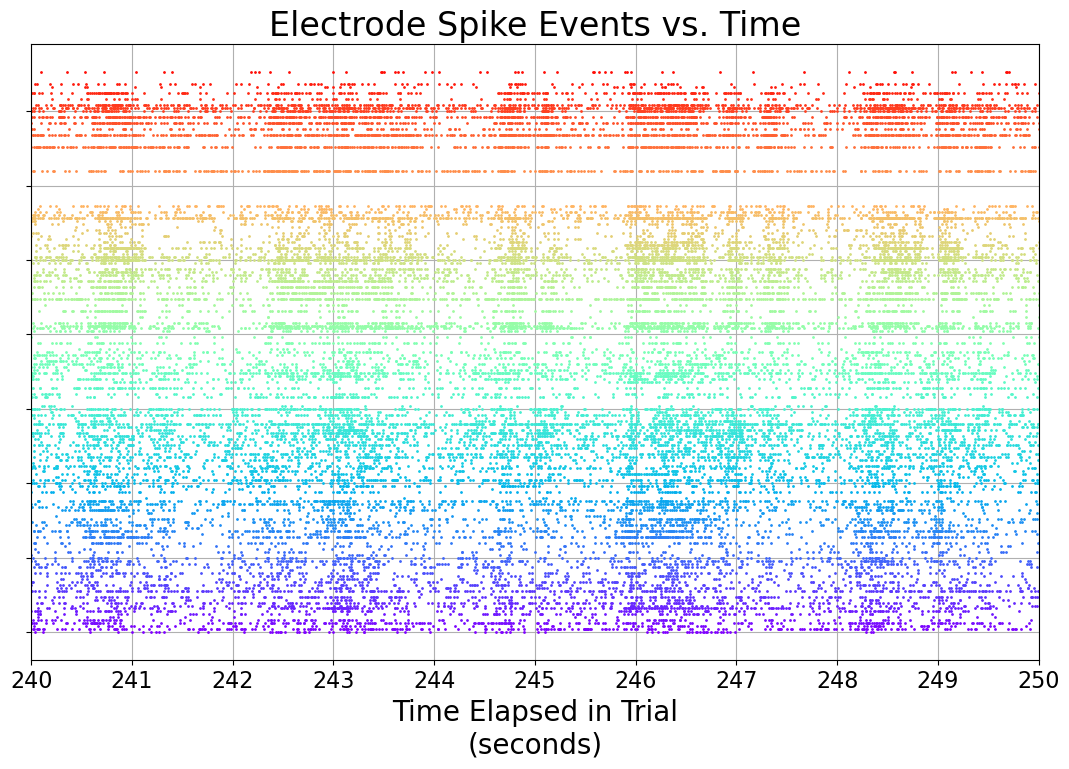

In [19]:
# assign a color for each electrode channel
color = plt.cm.rainbow(np.linspace(0, 1, len(Espks)))

# plot every neuron spike array
plt.figure(figsize=(13,8))
i = 0 # variable for offsetting spike dots
for electrode in Espks:
    for neuron in electrode:
        if (neuron is not None):
            if (neuron.size > 1):
                offs = np.ones(len(neuron)) + i*100
                plt.plot(neuron, offs, '.', color=color[i], ms=2)
        
    i += 1
    
plt.xlim([240,250])
plt.xticks(np.arange(240,250+1,1))
plt.grid()
plt.xlabel("Time Elapsed in Trial\n(seconds)", fontsize=20)
plt.xticks(fontsize=16)
plt.title("Electrode Spike Events vs. Time", fontsize=24)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([]);

<font color='gray'>*Figure 3. This plot is over a snippet of time for a trial in the [O'Doherty et al., 2020](https://zenodo.org/records/3854034) dataset. In this plot, each SU array from the dictionary data variable "ESpks" output from the custom "load_data" function is plotted. Each SU spike sorted neuron is offset vertically. The markers across the horizontal indicate when a spike detected event occurred for a neuron corresponding to the vertical position of those horizontal mark sets. Dot color is unique to each electrode here. If there is complete white space across, where a neuron spike array would be, it means no data was recorded for that neuron during this session.*</font>

As evident by the plot above, the neural spike data right now is comprised of all the times when spikes were detected (for electrodes/neurons) and are thus asynchronous. This means that the variables **Sspks**, **Espks**, and **Mspks** will not align with the kinematic measurements that are sampled synchronously at a steady sample rate of $250\text{ Hz}$ (**cursor_pos**, **finger_pos**, and **target_pos**).

This asynchonous data becomes a problem for the main goal of the decoder: that is, to predict the kinematic state at the next time step given the state of the current observed (neural) data and the current kinematic state estimate. It is not possible to make these predictions if a decoder's model works synchronously and the observed is not updated/measured synchronously at each time step.

To convert the asynchronous neural spike data to synchronous data, the neural spikes can be "binned." In binning, the time vector in a session is divided into fixed windows, or "bins," and the neural data is converted into counts/number of spike occurances during each bin interval. In [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95), neural data was binned with bin intervals of $16\text{ ms}$, $32\text{ ms}$, $64\text{ ms}$, and $128\text{ ms}$. The same will be done in this project. It is also worth noting that these bin sizes will make the neural data periodic, but not at the same rate as the kinematic state measurements ($250\text{ Hz}$). To align the kinematic measurements with this new binned data, the kinematic measurements can be downsampled from $250\text{ Hz}$ to the new rate, $\frac{1}{\text{bin size}}$. To do the downsampling, a decimate function is called inside the "bin_data" function to ensure anti-aliasing of the kinematic states.

The code below makes use of a custom function, "bin_data," which does this binning and downsampling to sync up the data.

#### Partitioning Dataset into Training and Evaluation Datasets:

Another key concept is the idea of "training" and "evaluation." The neural decoders are to predict kinematic states from neural observations from some model that relates the data. In order to develop that model, its parameters must be "trained" from data. Therefore, each session is broken up into training and evaluation sets. The training set is used strictly for model tuning/to learn parameters for the predictive model. The evaluation set is used in determining how well the model predicts the kinematic state from the observations in the evaluation set. For all sessions, the neural decoding models are trained on data collected up to the first 320 seconds of the session and evaluated on all data collected after that.

On top of binning, the custom function "bin_data" (used below), splits the new synchronized data into "train" and "test" sets.

In [20]:
# binwidths used for binning neural spike data in Makin paper 
bin_widths_ms = [16, 32, 64, 128]

# bin spike data, resample all data to be in sync,
# and split into test and train sets
v = mt.bin_data(data,bin_width_ms=bin_widths_ms[0])


# extract variables from the binned data dictionary, v
## define print template and headers
printTemp = "{0:15} | {1:15}"
print(printTemp.format("Variable", "Size of Variable"))
for key,val in v.items():
    try:
        print(printTemp.format(f"{key}",f"{val.shape}"))
    except:    
        print(printTemp.format(f"{key}",f"{len(val)}"))

Variable        | Size of Variable
kinematic_train | (6, 20001)     
kinematic_test  | (6, 31111)     
su_spikes_train | (291, 20001)   
su_spikes_test  | (291, 31111)   
mu_spikes_train | (141, 20001)   
mu_spikes_test  | (141, 31111)   
t_train         | (20001,)       
t_test          | (31111,)       


This variables output here, from the code above and from the "bin_data" function, are all in sync and can now be used by the different decoders in training their models, making predictions, and collect results.

These new synchronous variables output from the code above can be defined as:

* **kinematic_train**: This is the ground truth kinematic states for the training set of the session and is sampled at $\frac{1}{\text{bin size}}$. This array has dimensions $(N,M)$, where $N$ is 6 for the kinematic states $x_{pos_x}$, $x_{pos_y}$, $x_{velo_x}$, $x_{velo_y}$, $x_{acc_x}$, and $x_{acc_y}$.
<br>
<br>
* **kinematic_test**: This is the ground truth kinematic states for the evaluation set of the session and is sampled at $\frac{1}{\text{bin size}}$. This array has dimensions $(N,M)$, where $N$ is 6 for the kinematic states $x_{pos_x}$, $x_{pos_y}$, $x_{velo_x}$, $x_{velo_y}$, $x_{acc_x}$, and $x_{acc_y}$.
<br>
<br>
* **su_spikes_train**: This is the binned single-unit neural spike counts of the training set. This array has dimensions $(C,M)$, where $C$ is the number of valid neurons.
<br>
<br>
* **su_spikes_test**: This is the binned single-unit neural spike counts of the evaluation set. This array has dimensions $(C,M)$, where $C$ is the number of valid neurons.
<br>
<br>
* **mu_spikes_train**: This is the binned multi-unit neural spike counts of the training set. This array has dimensions $(E,M)$, where $E$ is the number of electrodes.
<br>
<br>
* **mu_spikes_test**: This is the binned multi-unit neural spike counts of the evaluation set. This array has dimensions $(E,M)$, where $E$ is the number of electrodes.
<br>
<br>
* **t_train**: This is the time vector for the training set of the session and is sampled at $\frac{1}{\text{bin size}}$. This vector is length $M$.
<br>
<br>
* **t_test**: This is the time vector for the evaluation set of the session and is sampled at $\frac{1}{\text{bin size}}$. This vector is length $M$.

## Research Objectives

The objectives for this project are to:

1. Document and design and implement a Python library for conventional neural signal decoders for use with a published neural-kinematic dataset ([O'Doherty et al., 2020](https://zenodo.org/records/3854034)
) This will be done by demonstrating similarity to the performance metrics in the results file accompanying the dataset (ideally the results here should match exactly). The results were collected by [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) and the different decoder implementations are described there as well. The authors for [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) mention that they share MATLAB code at [Makin and O’Doherty 2018](https://github.com/jgmakin/rbmish) for their implementations. The metrics being compared are signal-to-noise ratio (SNR) and coefficient of determination ($R^2$) and can be computed from the outputs of the decoder, or the kinematic state estimates, and the ground truth kinematic state evaluation data. These metrics are defined as:

$$R^2 = 1 - \frac{\overline{(\pmb{X} - \pmb{\hat{X}})^2}}{\overline{(\pmb{X} - \bar{\pmb{X}})^2}}\tag{3}$$

$$SNR = -10log_{10}(1-R^2)\tag{4}$$

where, bar ( $\bar{}$ ) indicates sample average, hat ( $\hat{}$ ) indicates estimate, and $\pmb{X}$ are the kinematic states for all time steps in the evaluation partition for a session (nothing above $\pmb{X}$ indicates ground-truth kinematic data).

2. In objective 1 results are collected using single-unit neuron spike observations. After confirming that the decoders are implemented properly and match the results from a published paper that worked on the dataset, test the decoders ability to handle sub-optimal observational data. That is, simulate skipping of the spike sorting process by pooling all spike sorted data in each electrode. This will result in single spike arrays per electrode. Next, for the single-unit data, test the decoders ability to handle spikes that are missing by (uniform) randomly dropping spikes at different rates for a session. The drop rates to test for the sessions will be $5$ %, $15$ %, $25$ %, and $50$ %. For both the multi-unit (spike pooling) and spike dropping cases, quantify any improvements and/or by how much the decoders performance changed from single-unit baseline case with no dropping or pooling.

# Methods

The neural decoders are of main focus in [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) and this extended effort. Due to the limited time-frame at the time of this Master's Project, all decoders from [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) were not fully implemented. Only three decoders were implemented. The decoders featured here are regression, Kalman filter supervised, and Kalman filter unsupervised with static mapping (from latent to ground-truth). Prior to presenting these decoders, it is worth defining variable and notation definitions:

## Notations and Variable Definitions:

| Notation | Definition |
| --- | --- |
| lower case, non-bold, letter (e.g. $x$) | scalar |
| lower case, bold, letter (e.g. $\textbf{x}$) | vector |
| upper case, bold, letter (e.g. $\textbf{X}$) | matrix |
| Hat (e.g. $\hat{\textbf{X}})$ | Estimate |
| Bar (e.g. $\bar{\textbf{X}}$) | Sample Average |
| Single Quotation (e.g. $\textbf{X}'$) | Transpose of Matrix/Vector |
| Bar Power, Subscript $m$ (e.g. $\hat{\textbf{x}}_{m}^{-}$) | Is a prediction (made for time step $m$) |
| $E[\text{ }]$ | Expectation |
| $Cov[\text{ }]$ | Covariance |

| Variable | Size | Definition |
| ---------- | ---------------- | ------------------------------------------------------------------------------------------------------------------ |
| $M$ | scalar | Number of Samples. |
| $C$ | scalar | Number of Observed Neurons. |
| $E$ | scalar | Number of Observed Electrodes. |
| $N$ | scalar | Number of States to be predicted (e.g. # Kinematic states, # Latent states).|
| $x_{n,m}$ | scalar | $n$-th Kinematic State at time step $m$. |
| $\textbf{x}_m$ | ($N$,$1$) | Kinematic State Vector at time step $m$. |
| $\textbf{X}$ | ($N$,$M$) | Kinematic State Matrix (collection of $M$ successive Kinematic State Vectors). |
| $\textbf{X}_1$ | ($N$,$M-1$) | Current time step's Kinematic State Matrix (collection of Kinematic State Vectors measured/estimated at each of the $M-1$ time steps for that time step). |
| $\textbf{X}_2$ | ($N$,$M-1$) | Next time step's Kinematic State Matrix (collection of Kinematic State Vectors measured/estimated at each of the $M-1$ time steps for the next time step). |
| $z_{n,m}$ | scalar | $n$-th Latent State at time step $m$. |
| $\textbf{z}_m$ | ($N$,$1$) | Latent State Vector at time step $m$. |
| $\textbf{Z}$ | ($N$,$M$) | Latent State Matrix (collection of $M$ successive Latent State Vectors). |
| $\textbf{Z}_1$ | ($N$,$M-1$) | Current time step's Latent State Matrix (collection of Latent State Vectors measured/estimated at each of the $M-1$ time steps for that time step). |
| $\textbf{Z}_2$ | ($N$,$M-1$) | Next time step's Latent State Matrix (collection of Latent State Vectors measured/estimated at each of the $M-1$ time steps for the next time step).|
| $r_{c,m}$ | scalar | $c$-th Observation at time step $m$.|
| $\textbf{r}_m$ | ($C$,$1$) | Observation Vector at time step $m$. |
| $\textbf{R}$ | ($C$,$M$) | Observation Matrix (collection of $M$ successive Observation Vectors). |
| $\pmb{\beta}$ | ($N$,$C+1$) | Parameter Matrix used in the Linear Regression Decoder and a constant employed in Factor Analysis. |
| $\epsilon$ | N/A | Noise Distribution used in the Linear Regression Decoder and Factor Analysis. |
| $\pmb{\Psi}$ | ($C$,$C$) | The covariance matrix for the generative LGDS model used in Factor Analysis. |
| $\textbf{H}$ | ($C$,$N$) | Observation Matrix for the LGDS Neural-Kinematic (or Latent) model. |
| $\textbf{A}$ | ($N$,$N$) | State Transition Matrix for the LGDS Neural-Kinematic (or Latent) model. |
| $\textbf{h}$ | ($C$,$1$) | Observation Offset Vector for the LGDS Neural-Kinematic (or Latent) model. |
| $\textbf{a}$ | ($N$,$1$) | State Offset Vector for the LGDS Neural-Kinematic (or Latent) model. |
| $\textbf{q}$ | N/A | Is the observation noise associated with the LGDS Neural-Kinematic (or Latent) model.  |
| $\textbf{Q}$ | ($C$,$C$) | Observation Covariance Matrix for the LGDS Neural-Kinematic (or Latent) model. |
| $\textbf{w}$ | N/A | Is the process noise associated with the LGDS Neural-Kinematic (or Latent) model.  |
| $\textbf{W}$ | ($N$,$N$) | State Covariance Matrix for the LGDS Neural-Kinematic (or Latent) model. |
| $\textbf{P}^{-}_{m}$ | ($N$,$N$) | State Estimate Covariance Matrix prediction for the $m$-th step of the KF decoder ($m=0$ is the prior prediction).|
| $\pmb{\hat{x}}^{-}_{m}$ | ($N$,$N$) | State Estimate prediction for the $m$-th step of the KF decoder ($m=0$ is the prior prediction). |
| $\pmb{K}_m$ | ($N$,$C$) | Kalman Gain at time step $m$ for the KF decoder. |
| $\pmb{P}_m$ | ($N$,$C$) | State Estimate Covariance Matrix for the $m$-th step of the KF decoder. |
| $\textbf{L}$ | ($C$,$N$) | Factor Loading Matrix used in the Factor Analysis LGDS model. |
| $\pmb{\mu}$ | ($C$,$1$) | Mean of the observational data (used in Factor Analysis). |
| $\textbf{J}_{m}$ | ($N$,$N$) | Smoother Gain Matrix used in the KF Unsupervised Decoder. |
| $\pmb{\hat{z}}_{sm_{m}}$ | ($N$,$1$) | Smoothed/Refined Latent State Estimates (used in KF Unsupervised Decoder). |
| $\textbf{P}_{sm_{m-1}}$ | ($N$,$N$) | Smoothed/Refined Latent State Covariance Estimates (used in the KF Unsupervised Decoder). |
| $\textbf{P}_{sm_{m,m-1}}$ | ($N$,$N$) | Smoothed/Refined Latent State Covariance Extrapolation Estimates (used in the KF Unsupervised Decoder). |
| $\textbf{P}_{m,m-1}$ | ($N$,$N$) | Expected State Extrapolation Covariance Matrix (used in KF Unsupervised Decoder). |
| $\textbf{D}$ | ($N$,$N_{latent}$) | Static Mapping Matrix that transforms the latent states to the kinematic states (used in KF Unsupervised Static Mapping Decoder). |
| $\textbf{d}$ | ($N$,$1$) | Static Mapping Offset Vector that completes the linear transformation from latent state to kinematic states (used in KF Unsupervised Static Mapping Decoder). |
| $\textbf{I}_N$ | ($N$,$N$) | Identity Matrix. |

**Note**: In the above:

* If considering multi-unit data, the dimension $C$ for parameters changes to $E$.

## Neural Decoders:

### Regression
#### Linear Model

Regression is a method that essentially finds a line-of-best-fit between one variable and another. For this application, the kinematic states at time $m$, or $\pmb{x}_m$, is regressed on the neuron firing rates at time $m$, or $\pmb{r}_m$, via linear regression. This regression can be described mathematically as:

$$\pmb{X} = \pmb{\beta} \pmb{R}_A + \epsilon\tag{5}$$

where:

$\pmb{X} = [\pmb{x}_1, \pmb{x}_2, ..., \pmb{x}_M] \in (N,M)$

$\pmb{R}_A = [\pmb{1}; \pmb{R}] \in (C+1,M)$

$\pmb{R} = [\pmb{r}_1, \pmb{r}_2, ..., \pmb{r}_M] \in (C,M)$

$\pmb{\beta} = [\pmb{\beta}_0, \pmb{\beta}_1, \pmb{\beta}_2, ..., \pmb{\beta}_C] \in (N,C+1)$

with,

$\pmb{x}_m = [x_{1,m}, x_{2,m}, ..., x_{N,m}]^T$ being a column vector with $N$ kinematic states at time $m$.

$\pmb{r}_m = [r_{1,m}, r_{2,m}, ..., r_{C,m}]^T$ being a column vector with $C$ observations (binned neural spikes) at time $m$.

$\pmb{\beta}_c = [\beta_{1,c}, \beta_{2,c}, ..., \beta_{N,c}]^T, \text{ }c\ne0,$ being a column vector comprised of $N$ coefficients. The $n$-th coefficient in this vector represents essentially how much the $c$-th observation contributes toward the transformation to the $n$-th kinematic state.

$\pmb{\beta}_0 = [\beta_{1,0}, \beta_{2,0}, ..., \beta_{N,0}]^T$ being an $N$ element column vector with each element representing an offset. Each offset in the vector is positioned with respect to the state that it is to complete the linear transformation for.

Note that the rows of $\pmb{\beta}$ are comprised of the coefficients that transform (collectively) the $m$-th observation vector, $\pmb{r}_m$, to the $n$-th state at time $m$, or $x_{n,m}$. Each row of $\pmb{\beta}$ is made up of weights that determine how much each observed element (respective to coefficient element) contribute in the transformation to the output state, $n$. The $\beta_{n,0}$ term of that row combines with a 1 to scale up or down the transformation by $\beta_{n,0}$ to compensate for an expected offset.

$\epsilon$ is the unaccounted for noise associated with the model (needed to make the model exact).

Now, to solve for the parameters, $\pmb{\beta}$ of the model, an objective function, $S(\pmb{\beta})$ is used. The objective will be to solve for the $\pmb{\beta}$ that minimizes the mean square of the error, or:

$$S(\pmb{\beta}) = \|\pmb{X} - \pmb{\beta} \pmb{R}_A\|^2\tag{6}$$

expanding this:

$$= (\pmb{X} - \pmb{\beta} \pmb{R}_A)(\pmb{X} - \pmb{\beta} \pmb{R}_A)'$$

$$= \pmb{X}\pmb{X}' - \pmb{X} \pmb{R}_A' \pmb{\beta}' - \pmb{\beta} \pmb{R}_A \pmb{X}' + \pmb{\beta} \pmb{R}_A \pmb{R}_A' \pmb{\beta}'$$

#### Training

To minimize this, take the derivative with respect to $\pmb{\beta}$ and set this equal to 0:

$$\frac{dS(\pmb{\beta})}{d\pmb{\beta}} = -\pmb{X} \pmb{R}_A' - \pmb{R}_A \pmb{X}' + 2 \pmb{\beta} \pmb{R}_A \pmb{R}_A' = 0$$

$$= -2\pmb{X} \pmb{R}_A' + 2 \pmb{\beta} \pmb{R}_A \pmb{R}_A'$$

$$\Rightarrow \pmb{X} \pmb{R}_A' = \pmb{\beta} \pmb{R}_A \pmb{R}_A'$$

$$\Rightarrow \boxed{\pmb{\beta} = \pmb{X} \pmb{R}_A' (\pmb{R}_A \pmb{R}_A')^{-1}}\tag{7}$$

This is called a least squares approximation.

Finally, note that to solve equation 5, data must be collected to fill out the $\pmb{X}$ and $\pmb{R}$ matrices. This is done over a subset of the session data. In [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95), this subset was defined as the first $320\text{ seconds}$ of the session. This subset is called "training" data and the same approach is applied here. All data following that is called "test"/"evaluation" data. Following training, and with the "test" subset, the neural data is plugged into equation 5 above (neglecting $\epsilon$) and kinematic states, $\pmb{\hat{X}}$, for the "test" subset are predicted and compared to the true data from the experiment. $SNR$ and $R^2$ metrics are used to compare how well this decoder works. The code below does the training and evaluation for all session kinematic state/bin width combinations for the regression decoder.

#### Run Regression Implementation and Log Results:

The first code snippet below will collect results for the main experiment, or the one that validates the implementation for the decoders (the SU results that are reported by [O'Doherty et al., 2020](https://zenodo.org/records/3854034)
) The next code snippet collects the multi-unit results for the regression decoder, or that when the neural data input to the regression model are the pooled electrode spikes (spike sorting abandoned). The last code snippet collects the results for the four spike dropped cases for the regression decoder ($5$ %, $15$ %, $25$ %, and $50$ % of spikes dropped).

##### Single-Unit Regression Results:

In [28]:
resultsDir = os.getcwd() + r"\single_unit_results"
df_regress = mt.collectResults(decoder="regression",\
                               dataDir=os.getcwd(),\
                               resultsDir=resultsDir,\
                               bMU=False, dropPercent=0,\
                               bTransferLearn=False,\
                               bUseOldResults=True,\
                               bNewFile=True, fExt=0,\
                               bPrintRes=False,\
                               bSaveParams=False)
df_regress

session monkey  num_neurons  num_training_samples  \
0     indy_20160407_02   indy          291                 20001   
1     indy_20160407_02   indy          291                 20001   
2     indy_20160407_02   indy          291                 20001   
3     indy_20160407_02   indy          291                 20001   
4     indy_20160407_02   indy          291                 20001   
...                ...    ...          ...                   ...   
1123  loco_20170302_02   loco          500                  2501   
1124  loco_20170302_02   loco          500                  2501   
1125  loco_20170302_02   loco          500                  2501   
1126  loco_20170302_02   loco          500                  2501   
1127  loco_20170302_02   loco          500                  2501   

      num_testing_samples kinematic_axis  bin_width     decoder       rsq  \
0                   31111           posx         16  regression  0.073790   
1                   31111           posy         16  regression  0.103486   
2                   31111           velx         16  regression  0.200799   
3                   31111           vely         16  regression  0.243252   
4                   31111           accx         16  regression  0.043045   
...                   ...            ...        ...         ...       ...   
1123                15338           posy        128  regression  0.206600   
1124                15338           velx        128  regression -0.045028   
1125                15338           vely        128  regression  0.222251   
1126                15338           accx        128  regression -0.254173   
1127                15338           accy        128  regression -0.109364   

           snr  
0     0.332903  
1     0.474428  
2     0.973442  
3     1.210485  
4     0.191084  
...        ...  
1123  1.005079  
1124 -0.191278  
1125  1.091606  
1126 -0.983573  
1127 -0.450740  

[1128 rows x 10 columns]

##### Multi-Unit Regression Results:

In [29]:
resultsDirMU = os.getcwd() + r"\multi_unit_results"
df_regressMU = mt.collectResults(decoder="regression",\
                                 dataDir=os.getcwd(),\
                                 resultsDir=resultsDirMU,\
                                 bMU=True, dropPercent=0,\
                                 bTransferLearn=False,\
                                 bUseOldResults=True,\
                                 bNewFile=True, fExt=0,\
                                 bPrintRes=False,\
                                 bSaveParams=False)

##### Spike Dropped Regression Results:

In [30]:
resultsDirDrop = os.getcwd() + r"\dropped_spikes_results"
df_regressD05 = mt.collectResults(decoder="regression",\
                                  dataDir=os.getcwd(),\
                                  resultsDir=resultsDirDrop,\
                                  bMU=False, dropPercent=5,\
                                  bTransferLearn=False,\
                                  bUseOldResults=True,\
                                  bNewFile=True, fExt=1,\
                                  bPrintRes=False,\
                                  bSaveParams=False)

df_regressD15 = mt.collectResults(decoder="regression",\
                                  dataDir=os.getcwd(),\
                                  resultsDir=resultsDirDrop,\
                                  bMU=False, dropPercent=15,\
                                  bTransferLearn=False,\
                                  bUseOldResults=True,\
                                  bNewFile=True, fExt=1,\
                                  bPrintRes=False,\
                                  bSaveParams=False)

df_regressD25 = mt.collectResults(decoder="regression",\
                                  dataDir=os.getcwd(),\
                                  resultsDir=resultsDirDrop,\
                                  bMU=False, dropPercent=25,\
                                  bTransferLearn=False,\
                                  bUseOldResults=True,\
                                  bNewFile=True, fExt=1,\
                                  bPrintRes=False,\
                                  bSaveParams=False)

df_regressD50 = mt.collectResults(decoder="regression",\
                                  dataDir=os.getcwd(),\
                                  resultsDir=resultsDirDrop,\
                                  bMU=False, dropPercent=50,\
                                  bTransferLearn=False,\
                                  bUseOldResults=True,\
                                  bNewFile=True, fExt=1,\
                                  bPrintRes=False,\
                                  bSaveParams=False)

### Kalman Filter Supervised/Observed

#### LGDS model

The Kalman Filter (KF) decoder is one which employs knowledge of a system's dynamical model, noisy measurements, and the uncertainties (or noise) in the model and measurements to make an estimate about a system's state(s) over time. By using all of this knowledge, the KF is able to make an informed estimate about the system state(s), resulting in better estimation when compared to estimating from measurements alone. The KF typically involves a linear gaussian dynamical system (LGDS). For this application, a state-space LGDS model is defined and used in the KF decoder, specifically:

$$\pmb{r}_m = \pmb{H}\pmb{x}_m + \pmb{h} + q\tag{8}$$
$$\pmb{x}_{m+1} = \pmb{A}\pmb{x}_m + \pmb{a} + w\tag{9}$$

Equation (6) is defined as the measurement equation and equation (7) is defined as the state extrapolation equation. The parameters for those equations can be defined as,

$\pmb{H} \in (C,N)$ is the <ins>observation matrix</ins>, which transforms the state vector, $\pmb{x}_m$, to the observation space.

$\pmb{A} \in (N,N)$ is the <ins>state transition matrix</ins>, which transforms the state vector at the current time ($m$), $\pmb{x}_m$, to the space associated with the state vector at the very next time step ($m+1$), $\pmb{x}_{m+1}$.

$\pmb{h} \in (C,1)$ is the <ins>observation offset vector</ins> or <ins>mean</ins> and scales up or down $\pmb{H}\pmb{x}_m$ to complete the transformation from $\pmb{x}_m$ to $\pmb{r}_m$.

$\pmb{a} \in (N,1)$ is the <ins>state offset vector</ins> or <ins>mean</ins> and scales up or down $\pmb{A}\pmb{x}_m$ to complete the transformation from $\pmb{x}_m$ to $\pmb{x}_{m+1}$.

$q \sim N(0,\pmb{Q})$ is the <ins>observation noise</ins> and essentially informs the KF as to how much trust can be given into computing an estimate from the measurements alone. $\pmb{Q} \in (C,C)$ is the observation covariance.

$w \sim N(0,\pmb{W})$ is the <ins>process noise</ins> and essentially informs the KF as to how much trust can be given into computing an estimate from the model alone. $\pmb{W} \in (N,N)$ is the state covariance.

<ins>Note</ins>: While this model could be time-varying, where the parameters change with time, the system here is assummed time-invariant with independent and identically distributed (IID) random variables. I.e., the parameters of the model $\pmb{H}$, $\pmb{h}$, $\pmb{Q}$, $\pmb{A}$, $\pmb{a}$, and $\pmb{W}$ are constant.
<br>
<br>

#### Training

In the Kalman Filter observed, the parameters will be learned from the training dataset (i.e. the first 320 seconds of a session) using the actual ground truth kinematic states--$\pmb{X}$. The $\pmb{H}$, $\pmb{h}$, $\pmb{A}$, and $\pmb{a}$ parameters will be learned via linear regression using a least squares approximation (as derived in the "regression" decoder section). The $\pmb{Q}$ and $\pmb{W}$ covariance matricies can then be found by squaring the errors (difference in actual from the approximation by the LGDS model), normalized by the number of samples used, $M$. I.e., these parameters can be found as follows:

$$[\pmb{h}, \pmb{H}] = \pmb{R} \pmb{X}_A'(\pmb{X}_A\pmb{X}_A')^{−1}\tag{10}$$ 
 
$$[\pmb{a}, \pmb{A}] = \pmb{X}_2 \pmb{X}_{A_1}'(\pmb{X}_{A_1} \pmb{X}_{A_1}')^{-1}\tag{11}$$

$$\pmb{Q} = \frac{(\pmb{R}-(\pmb{H}\pmb{X}+\pmb{h}))(\pmb{R}-(\pmb{H}\pmb{X}+\pmb{h}))^T}{M}\tag{10}$$ 

$$\pmb{W} = \frac{(\pmb{X}_2 - (\pmb{A}\pmb{X}_1 + \pmb{a}))(\pmb{X}_2 - (\pmb{A}\pmb{X}_1 + \pmb{a}))^T}{M-1}\tag{12}$$ 

where, in the above:

$\pmb{X}_A = [1; \pmb{X}] \in (N+1,M)$

$\pmb{X}_{A_1} = [1; \pmb{X}_1] \in (N+1,M-1)$

$\pmb{X}_1 = [\pmb{x}_1, \pmb{x}_2, ..., \pmb{x}_{M-1}] \in (N,M-1)$

$\pmb{X}_2 = [\pmb{x}_2, \pmb{x}_3, ..., \pmb{x}_M] \in (N,M-1)$

$\pmb{X}$ and $\pmb{X}_1$ are prepended with a row of 1's to form $\pmb{X}_A$ and $\pmb{X}_{A_1}$ so that the offset vectors $\pmb{h}$ and $\pmb{a}$ can be found. These offset vectors are the first columns of the output matrix in equations (8) and (9), respectively.
<br>
<br>

#### Estimation

After learning the parameters, the KF can be implemented on the test data in the following series of steps:

##### Initialize
Time step is $0$ here.

Make assumptions on prior knowledge (*a priori*) for the first outcome of a trial. I.e. What is the first estimated state prediction ($\pmb{\hat{x}}_{0}^{-}$)? What is the uncertainty in that initial prediction ($\pmb{P}^{-}_{0}$)?

In Makin et al., 2018, the initial state and uncertainty in the initial state is assumed as the mean and convariance, respectively, over all kinematic state measurements from the training dataset, or:

$$\pmb{\hat{x}}_{0}^{-} = \bar{\pmb{X}}\tag{13}$$

$$\pmb{P}^{-}_{0} = \text{cov}(\pmb{X},\pmb{X})\tag{14}$$

where, equation (12) is the sample average for each state vector in the training set (i.e. average across columns of $\pmb{X}$) and $\pmb{\hat{x}}_{0}^{-} \in (N,1)$ and $\pmb{P}^{-}_{0} \in (N,N)$.
<br>
<br>

##### Measure

Increment to newest time step and collect this time step's neural observation vector, $\pmb{r}_m$.
<br>
<br>

##### Update (*posteriori*)
Solve the following Equations:

*Calculate the Kalman Gain (***Kalman Gain Equation***)*:
$$\pmb{K}_m = \pmb{P}^{-}_m\pmb{H}'(\pmb{H}\pmb{P}^{-}_m\pmb{H}' + \pmb{Q})^{-1}\tag{15}$$

*Estimate the Current State (***State Update Equation***)*:
$$\pmb{\hat{x}}_m = \pmb{\hat{x}}^{-}_m + \pmb{K}_m(\pmb{r}_m - (\pmb{H}\pmb{\hat{x}}^{-}_m + \pmb{h}))\tag{16}$$

*Update the Current Estimate Uncertainty (***Covariance Update Equation***)*:
$$\pmb{P}_m = (\pmb{I}_N - \pmb{K}_m\pmb{H})\pmb{P}^{-}_m\tag{17}$$

where, $\pmb{K}_m \in (N,C)$ is a matrix that dynamically updates at each time step. It essentially weights the prediction and the result from measured data at time step $m$ to determine how much of each to use in computing the final estimate for state and uncertainty at time $m$.
<br>
<br>

##### Predict the Next State and Estimate Uncertainty in that Prediction (*a priori*):
Solve the following Equations:

*Predict the next state (***State Extrapolation Equation***)*:
$$\pmb{\hat{x}}_{m+1}^{-} = \pmb{A}\pmb{\hat{x}}_{m} + \pmb{a}\tag{18}$$

*Extrapolate Estimate Uncertainty (***Covariance Extrapolation Equation***)*:
$$\pmb{P}^{-}_{m+1} = \pmb{A}\pmb{P}_{m}\pmb{A}' + \pmb{W}\tag{19}$$
<br>
<br>

##### Repeat steps 2-4 for Each Time Step in the test trial.

#### Run Kalman Filter Supervised Implementation and Log Results:

The first code snippet below will collect results for the main experiment, or the one that validates the implementation for the decoders (the SU results that are reported by [O'Doherty et al., 2020](https://zenodo.org/records/3854034)). The next code snippet collects the multi-unit results for the KF supervised (or KF observed) decoder, or that when the neural data input to the KF supervised model are the pooled electrode spikes (spike sorting abandoned). The last code snippet collects the results for the four spike dropped cases for the KF supervised decoder ($5$ %, $15$ %, $25$ %, and $50$ % of spikes dropped).

##### Single-Unit KF Supervised Results:

In [31]:
resultsDir = os.getcwd() + r"\single_unit_results"
df_kfObs = mt.collectResults(decoder="KF_observed",\
                             dataDir=os.getcwd(),\
                             resultsDir=resultsDir,\
                             bMU=False, dropPercent=0,\
                             bTransferLearn=False,\
                             bUseOldResults=True,\
                             bNewFile=True, fExt=0,\
                             bPrintRes=False,\
                             bSaveParams=False)

df_kfObs

session monkey  num_neurons  num_training_samples  \
0     indy_20160407_02   indy          291                 20001   
1     indy_20160407_02   indy          291                 20001   
2     indy_20160407_02   indy          291                 20001   
3     indy_20160407_02   indy          291                 20001   
4     indy_20160407_02   indy          291                 20001   
...                ...    ...          ...                   ...   
1123  loco_20170302_02   loco          500                  2501   
1124  loco_20170302_02   loco          500                  2501   
1125  loco_20170302_02   loco          500                  2501   
1126  loco_20170302_02   loco          500                  2501   
1127  loco_20170302_02   loco          500                  2501   

      num_testing_samples kinematic_axis  bin_width      decoder       rsq  \
0                   31111           posx         16  KF_observed  0.654239   
1                   31111           posy         16  KF_observed  0.720598   
2                   31111           velx         16  KF_observed  0.464961   
3                   31111           vely         16  KF_observed  0.519963   
4                   31111           accx         16  KF_observed  0.019262   
...                   ...            ...        ...          ...       ...   
1123                15338           posy        128  KF_observed  0.465985   
1124                15338           velx        128  KF_observed  0.063036   
1125                15338           vely        128  KF_observed  0.398612   
1126                15338           accx        128  KF_observed -0.184109   
1127                15338           accy        128  KF_observed  0.006796   

           snr  
0     4.612244  
1     5.537712  
2     2.716147  
3     3.187252  
4     0.084469  
...        ...  
1123  2.724469  
1124  0.282771  
1125  2.208456  
1126 -0.733918  
1127  0.029615  

[1128 rows x 10 columns]

##### Multi-Unit KF Supervised Results:

In [32]:
resultsDirMU = os.getcwd() + r"\multi_unit_results"
df_kfObsMU = mt.collectResults(decoder="KF_observed",\
                               dataDir=os.getcwd(),\
                               resultsDir=resultsDirMU,\
                               bMU=True, dropPercent=0,\
                               bTransferLearn=False,\
                               bUseOldResults=True,\
                               bNewFile=True, fExt=0,\
                               bPrintRes=False,\
                               bSaveParams=False)

##### Spike Dropped KF Supervised Results:

In [33]:
resultsDirDrop = os.getcwd() + r"\dropped_spikes_results"
df_kfObsD05 = mt.collectResults(decoder="KF_observed",\
                                dataDir=os.getcwd(),\
                                resultsDir=resultsDirDrop,\
                                bMU=False, dropPercent=5,\
                                bTransferLearn=False,\
                                bUseOldResults=True,\
                                bNewFile=True, fExt=1,\
                                bPrintRes=False,\
                                bSaveParams=False)

df_kfObsD15 = mt.collectResults(decoder="KF_observed",\
                                dataDir=os.getcwd(),\
                                resultsDir=resultsDirDrop,\
                                bMU=False, dropPercent=15,\
                                bTransferLearn=False,\
                                bUseOldResults=True,\
                                bNewFile=True, fExt=1,\
                                bPrintRes=False,\
                                bSaveParams=False)

df_kfObsD25 = mt.collectResults(decoder="KF_observed",\
                                dataDir=os.getcwd(),\
                                resultsDir=resultsDirDrop,\
                                bMU=False, dropPercent=25,\
                                bTransferLearn=False,\
                                bUseOldResults=True,\
                                bNewFile=True, fExt=1,\
                                bPrintRes=False,\
                                bSaveParams=False)

df_kfObsD50 = mt.collectResults(decoder="KF_observed",\
                                dataDir=os.getcwd(),\
                                resultsDir=resultsDirDrop,\
                                bMU=False, dropPercent=50,\
                                bTransferLearn=False,\
                                bUseOldResults=True,\
                                bNewFile=True, fExt=1,\
                                bPrintRes=False,\
                                bSaveParams=False)

### Kalman Filter Unsupervised/Latent

#### LGDS Model

The KF unsupervised model assumes kinematic states are not measured and known. This decoder uses intermediate "latent" states which are estimated first from observed neural data. Then, from the "latent" states, the kinematic states are estimated. For this model, the LGDS is as follows:

$$\pmb{r}_m = \pmb{H}\pmb{z}_m + \pmb{h} + q\tag{20}$$
$$\pmb{z}_{m+1} = \pmb{A}\pmb{z}_m + \pmb{a} + w\tag{21}$$

These are the same equations as (6) and (7), with the exception being that the kinematic states, $\pmb{x}$, are replaced with the latent states, $\pmb{z}$.

#### Training

As stated before, the assumption with KF unsupervised is that the ground truth states, or the kinematic states, are not available. Thus, the training from the supervised case cannot be applied here. Instead an Expectation-Maximization (EM) algorithm is applied to learn the parameters that maximize the probability of observing the neural states in the training partition.

##### Perform Factor Analysis to Initialize the Latent States, their Uncertainty, and the Parameters for the LGDS

Prior to applying the EM algorithm for parameter discovery, initial values are to be assumed for the LGDS parameters and the latent states, $\pmb{Z}$ (for the training partition). Factor Analysis can be applied to perform initialization and help in preventing convergence to local maxima in the actual EM training to be applied for discovery of most likely LGDS parameters (section 3.2.2.). Factor Analysis will work to discover a generative model for the observational data (or the likelihood, $\mathcal{L}(\pmb{Z}|\pmb{R})$) and a generative model for the latent states (or the posterior, $p(\pmb{Z}|\pmb{R})$). Prior to applying factor analysis, some assumptions will be made that were made in [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95): first, the number of latent states will be set to one third the number of observations (or $\frac{1}{3}C$) (this was said to provide "the best results" for this dataset); secondly, to avoid over-fitting, the state ($\pmb{W}$) and observation ($\pmb{Q}$) covariance matrices are assumed diagonal. Factor Analysis models the observation, $\pmb{r}_m$, as a Linear-Gaussian generative model:

$$\pmb{r}_m = \pmb{L} \pmb{z}_m + \pmb{\mu} + \epsilon\tag{22}$$

where,

$\pmb{L} \in (C,N)$ is a factor loading matrix (where, here $N = \frac{1}{3}C$);

$\pmb{\mu} \in (C,1)$ is a constant, whose maximum likelihood estimator is the mean of the neural observation data (set to $\bar{\pmb{R}}$ for the training partition of the session to be decoded);

$\epsilon$ is the error or noise in the observations, where $\epsilon$~$N(0,\pmb{\Psi})$, with $\pmb{\Psi}$ being diagonal;

the prior distribution for the latent states is assumed:

$$p(\pmb{z}_m)\sim N(0\text{, }\pmb{I})\tag{23}$$

the generative model for the observations, or likelihood at time step $m$ is thus:

$$\mathcal{L}(\pmb{z}_m|\pmb{r}_m)= p(\pmb{r}_m|\pmb{z}_m)\sim N(\pmb{L}\pmb{z}_m + \pmb{\mu}\text{, }\pmb{\Psi})\tag{24}$$

With this knowledge, the posterior distribution can be deduced as (see appendix for derivation):

$$p(\pmb{z}_m|\pmb{r}_m)\sim N(\pmb{\beta}(\pmb{r}_m-\mu)\text{, }\pmb{I}_N-\pmb{\beta} \pmb{L})\tag{25}$$

with $\pmb{\beta} = \pmb{L}'(\pmb{L}\pmb{L}'+ \pmb{\Psi})^{-1}$.
<br>
<br>
<br>
Factor Analysis iterates between an "E" and an "M" step (and checks for convergence following that) The algorithm can be summarized as follows:

0. **Initialization Step** (initialize parameters for the model). The "E" step will need the LGDS parameters to compute the expectation values for the latent state, so initialize parameters $\pmb{L}$ and $\pmb{\Psi}$ here. This step is done only initially and then steps 1-3 are iterated over repeatedly. In this project, $\pmb{\Psi}$ is initialized as the sample variance computed over the training observation partition. The factor loading matrix $\pmb{L}$ is initialized by with the "Loading" matrix from Principal Components Analysis (PCA) (see [Centellegher 2023](https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html)). This is done by computing the singular value decomposition (SVD) on the observational training partition and using the SVD matricies to compute the "Loading" matrix, as follows:

   Compute SVD:

   $$\pmb{R}=\pmb{U}\pmb{S}\pmb{V}'$$

   * $\pmb{U}$ matrix contains the left singular vectors (or "principal components") of $\pmb{R}$.
   * $\pmb{S}$ matrix contains the singular values of $\pmb{R}$.
   * $\pmb{V}$ matrix has columns which contain the "principal axes" of $\pmb{R}$.
  
   The $\pmb{S}$ and $\pmb{V}$ matricies can be combined to compute Loading Matrix:

   $$\pmb{L}=\pmb{V}\frac{\pmb{S}}{\sqrt{M-1}}$$
    

1. **E Step** (update posteriors). Find the expectation of the latent states given all the observational data ($E[\pmb{z}_m|\pmb{r}_m,\pmb{\theta}]$) and the expectation of the second moment of the latent states given the observational data ($E[\pmb{z}_m\pmb{z}_m'|\pmb{r}_m],\pmb{\theta}$). Note: $\pmb{\theta}$ is all the latest update for parameters $\pmb{L}$ and $\epsilon$:

$$E[\pmb{z}_m|\pmb{r}_m,\pmb{\theta}] = \pmb{\beta}(\pmb{R}-\mu)\tag{26}$$
<br>
$$E[\pmb{z}_m\pmb{z}_m'|\pmb{r}_m,\pmb{\theta}] = Cov(\pmb{z}_m|\pmb{r}_m,\pmb{\theta}) + E[\pmb{z}_m|\pmb{r}_m,\pmb{\theta}]\text{ }E[\pmb{z}_m|\pmb{r}_m,\pmb{\theta}]'$$

$$= \pmb{I}_N-\pmb{\beta} \pmb{L} + \pmb{\beta}(\pmb{r}_m-\pmb{\mu})\text{ }(\pmb{r}_m-\pmb{\mu})'\pmb{\beta}'\tag{27}$$

which result from using the posterior distribution mean and covariance (Equation 25). At this step, iterate and solve for all $M$ samples in the training partition.

2. **M Step** (maximize likelihood). Find the parameters ($\pmb{L}$ and $\epsilon$) that maximize the likelihood for all the observational data (all time steps) given the latest update for the expected latent states (refer to Equation 24). This is done by taking the derivative, with respect to the parameters $\pmb{L}$ and $\pmb{\Psi}$ (separately), for the log likelihood of all observational data (given the latent states) (Equation 28) and setting that derivative to 0 and solving for the respective parameter. Equation 28 makes use of the standard equation for a multivariate Gaussian density function. After taking the derivative of equation 28 with respect to the parameters of interest and setting that equal to 0, Equations 29 and 30 can be derived to give the parameter that maximizes the likelihood of the latent states given the observations.

$$log(p(\pmb{R}|\pmb{Z})) = log(\prod_{m=1}^{M}\frac{exp(-\frac{1}{2}(\pmb{r}_m-\pmb{\mu}-\pmb{L}\pmb{z}_m)'\pmb{\Psi}^{-1}(\pmb{r}_m-\pmb{\mu}-\pmb{L}\pmb{z}_m))}{\sqrt{(2\pi)^C |{\pmb{\Psi}}|}})\tag{28}$$
<br>
$$\pmb{L}=(\sum_{m=1}^M (\pmb{r}_m-\pmb{\mu}) E[\pmb{z}_m|\pmb{r}_m]')(\sum_{m=1}^M E[\pmb{z}_m\pmb{z}_m'|\pmb{r}_m])^{-1}\tag{29}$$

$$\pmb{\Psi}=\frac{1}{M}\text{diag}[\sum_{m=1}^M{(\pmb{r}_m-\mu) (\pmb{r}_m-\pmb{\mu})'}-L E[\pmb{z}_m|\pmb{r}_m](\pmb{r}_m-\pmb{\mu})']\tag{30}$$

For Equations 29 and 30, plug in the results for the expectations computed in the "E" step where appropriate. In equation 30, use the newest updated $\pmb{L}$ parameter (output of Equation 29). Also, the "diag()" function in Equation 30 means to set all of the off-diagonal elements for the matrix computed inside the "diag" function to 0.

3. **Check for Convergence Step**. Stop the EM algorithm if $100$ EM iterations has passed or if the Gaussian cross-entropy for the observations has decreased by $\frac{1}{100}$ of the total decrease since initiating the EM algorithm:

   Cross-entropy for observational data can be found by taking the log of the product of Gaussian density functions for all samples in the $\pmb{R}$ partition. $\pmb{R} \sim N(\pmb{\mu},\pmb{L}\pmb{L}' + \pmb{\Psi})$ (Note: $Cov[\pmb{R},\pmb{R}]$ is derived in the appendix as $\pmb{L}\pmb{L}' + \pmb{\Psi}$): 

    $$log(\prod_{m=1}^M p(\pmb{r}_m)) = \sum_{m=1}^M log(N(\pmb{\mu},\pmb{L}\pmb{L}' + \pmb{\Psi}))\tag{31}$$

##### Perform Expectation Maximization to Learn the Parameters with the Maximum Likelihood

Following FA, an EM algorithm (different than FA's) can now be applied to learn the LGDS parameters for the model in Equations (20) and (21). The following steps are taken:

0. **Initialization Step** (Initialize the parameters for the LGDS and the initial latent state and its covariance). The parameters, initial latent state, and initial latent covariance will be initialized as follows:

    $$\pmb{Q}=\pmb{\Psi}$$

    This is initialized to the covariance of the likelihood function learned in FA (or $Cov[\pmb{R}|\pmb{Z}]$).

    $$\pmb{W}=\pmb{I}_N-\pmb{\beta} \pmb{L}$$

    This is initialized to the covariance for the posterior distribution learned in FA (or $Cov[\pmb{R}|\pmb{Z}]$)

    $$\pmb{H}=\pmb{L}$$

    This is initialized to the factor loading matrix learned in FA, which transforms the latent states to the observational data in FA.

    $$\pmb{A}=\pmb{I_N}$$

    Here $\pmb{A}$ is simply set to an identity matrix.

    $$\pmb{\hat{z}}^{-}_0=E[\pmb{Z}|\pmb{R}]$$

    This is initialized to the sample average of the expected latent states learned at each time step in FA.
    
    $$\pmb{P}^{-}_0=Cov[\pmb{Z}|\pmb{R}]$$

    This is initialized to the sample covariance of the expected latent states learned at each time step in FA.

    $$\pmb{a}=0$$

    Here the latent estimates will be assumed to have 0 mean as was assumed in FA.

    $$\pmb{h}=0$$

    The observation offset vector will be assumed 0 and the mean will be removed from the observations, $\pmb{R}$, as done in FA; however, after training, the mean of the observations will be accounted for in the model and factored back into the model as the $\pmb{h}$ vector.
<br>

1. **E Step** (update posteriors). At the Expectation step, the approach by [Shumway and Stoffer 1982](https://www.semanticscholar.org/paper/AN-APPROACH-TO-TIME-SERIES-SMOOTHING-AND-USING-THE-Shumway-Stoffer/658ee89b35cde8dae323452f01146b6176b2ece8) is taken to compute the expected values for the latent state and their covariances. Those authors first perform a forward Kalman Filter recursion to compute posterior estimates for the latent states; then, they refine those estimates by working backwards to essentially smooth the data in light of future data. The smoothing backward recursion algorithm is known as the Rauch-Tung-Striebel Smoother. This can be outlined as follows: 

   1.1. First, apply the KF estimator as done in section 2.3 in the supervised case. In this case, the latent state estimates ($\pmb{\hat{z}_m}$), the uncertainty in the estimates ($\pmb{P}_m$), and the prediction for the uncertainty of the estimates ($\pmb{P}^{-}_m$) at each time step is retained. The final Kalman Gain ($\pmb{K}$) computed in the KF will also be retained for use in the smoother to follow in this "E" step.
   
   1.2. Second, apply the **Rauch-Tung-Striebel Smoother** to refine the KF estimates and compute an additional parameter needed for the "M" step to follow this "E" step. The KF estimates being refined are the expected latent states and their covariance at each time step. The additional parameter being computed here is the covariance matrix for the previous and current state, which describes the uncertainty in extrapolation estimate from one latent state to its next ($\pmb{P}_{m,m-1}$). The Rauch-Tung-Striebel Smoother will iterate from the $M$-th sample to the first sample in the training partition and compute Equations 32-35 as follows:

   $$\pmb{J}_{m-1}=\pmb{P}_{m-1}\pmb{A}'(\pmb{P}_{m-1}^{-})^{-1}\tag{32}$$

    where, $\pmb{J}$ is the "smoother gain matrix".

   $$\pmb{\hat{z}}_{sm_{m-1}}=\pmb{\hat{z}}_{m-1} +
   \pmb{J}_{m-1}(\pmb{\hat{z}}_{sm_{m}} - \pmb{A}\pmb{\hat{z}}_{m-1})\tag{33}$$

   $$\pmb{P}_{sm_{m-1}}=\pmb{P}_{m-1} +
   \pmb{J}_{m-1}(\pmb{P}_{sm_{m}} - \pmb{P}_{m-1}^{-})\pmb{J}_{m-1}'\tag{34}$$

   where, $\pmb{\hat{z}_{sm}}$ and $\pmb{P}_{sm}$ are the smoothed, refined KF latent state estimates and their covariance matrices, respectively ($\pmb{\hat{z}}$ and $\pmb{P}$). Note: $\pmb{\hat{z}}_{sm_M}$ and $\pmb{P}_{sm_M}$ are set to their respective KF estimates ($\pmb{\hat{z}_M}$ and $\pmb{P}_M$).

   $$\pmb{P}_{sm_{m-1,m-2}}=\pmb{P}_{m-1}\pmb{J}_{m-2}' +
   \pmb{J}_{m-1}(\pmb{P}_{sm_{M,M-1}} - \pmb{A}\pmb{P}_{m-1})\pmb{J}_{m-2}'\tag{35}$$

   Note: Equation (35) will lag an iteration before it is first computed so that $\pmb{J}_{m-2}$ is had. Though, at the first iteration the following will be computed (Note: $\pmb{K_M}$ is the Kalman gain computed at the last time step from the KF algorithm run in 1.1.):

   $$\pmb{P}_{sm_{M,M-1}}=(\pmb{I}_N - \pmb{K}_M\pmb{H})\pmb{A}\pmb{P}_{m-1}$$


    Following this backward recursion, the KF estimates, or the expected values for the latent states at each time step and their covariance, are then refined and $\pmb{P_{m,m-1}}$ (at each time step) is computed in the following way:

   $$\pmb{\hat{z}}_m=\pmb{\hat{z}}_{sm_m}\tag{36}$$

   $$\pmb{P}_m=\pmb{P}_{sm_m} + \pmb{\hat{z}}_{sm_m}\pmb{\hat{z}}_{sm_m}'\tag{37}$$

   $$\pmb{P}_{m,m-1}=\pmb{P}_{sm_{M,M-1}} + \pmb{\hat{z}}_{sm_m}\pmb{\hat{z}}_{sm_{m-1}}'\tag{38}$$

3. **M Step** (maximize likelihood). This step finds all parameters that maximize the expected joint log likelihood for the latent and observed variables, given the observed data. This expected joint log likelihood is given by: 

$$E[log(p(\pmb{Z},\pmb{R})|\pmb{R})]=E[log(p(\pmb{z}_1)\prod_{m=2}^M p(\pmb{z}_m|\pmb{z}_{m-1}) \prod_{m=1}^M p(\pmb{r}_m|\pmb{z}_m))]\tag{39}$$

where,

$p(\pmb{z}_1) \sim N(\pmb{z}_0,\pmb{P}_{0})$

$p(\pmb{z}_m|\pmb{z}_{m-1}) \sim N(\pmb{A}\pmb{z}_{m-1}\text{, }\pmb{W})$

$p(\pmb{r}_m|\pmb{z}_m) \sim N(\pmb{H}\pmb{z}_m\text{, }\pmb{Q})$.

Here, $p(\pmb{z}_m|\pmb{z}_{m-1})$ and $p(\pmb{r}_m|\pmb{z}_m)$ are a result of the LGDS model. 

By differentiating Equation (32) with respect to the parameter of interest and then setting that equation to 0, the parameter that maximizes the likelihood can be solved for. The following equations are a result of doing that and are computed/updated on each pass of this "M" step:

$$\pmb{H}=(\sum_{m=1}^M \pmb{r}_m\pmb{\hat{z}}_m')(\sum_{m=1}^M E[\pmb{z}_m\pmb{z}_m'|\pmb{R}])^{-1}\tag{40}$$

$$\pmb{Q}=\frac{1}{M} \sum_{m=1}^M (\pmb{r}_m\pmb{r}_m' - \pmb{H}\pmb{\hat{z}}_m\pmb{r}_m')\tag{41}$$

$$\pmb{A}=(\sum_{m=2}^M E[\pmb{z}_m\pmb{z}_{m-1}'|\pmb{R}])(\sum_{m=2}^M E[\pmb{z}_{m-1}\pmb{z}_{m-1}'|\pmb{R}])^{-1}\tag{42}$$

$$\pmb{W}=\frac{1}{M-1} (\sum_{m=2}^M E[\pmb{z}_m\pmb{z}_m'|\pmb{R}] - \pmb{A} \sum_{m=2}^M E[\pmb{z}_{m-1}\pmb{z}_{m}'|\pmb{R}])\tag{43}$$

$$\pmb{z}_0=\pmb{\hat{z}}_1\tag{44}$$

$$\pmb{P}_0=E[\pmb{z}_{1} \pmb{z}_{1}'|\pmb{R}] -
\pmb{\bar{\hat{z}}}_1 \pmb{\bar{\hat{z}}}_1' +
\frac{1}{N} \sum_{n=1}^N (\hat{z}_{n,1}-\bar{\hat{z}}_1)(\hat{z}_{n,1}-\bar{\hat{z}}_1)'\tag{45}$$

Note: $\pmb{\bar{\hat{z}}}_1$ is the sample average across all latent states at time step 1.

3. **Check for Convergence Step**. If $100$ EM iterations were performed, training is complete (no more iterating between "E" and "M" here, move on). Otherwise, compare the average change in parameter elements from one "M" step to the next. If the max of those average parameter changes from one step to the next is $\lt 0.005$, then stop the EM training here and move onto the estimation step (Section 3.3.).

#### Estimation of Latent States

The Kalman Filter unsupervised runs the same KF estimation algorithm as the supervised version (see section 2.3.). The difference here though is that the KF estimation algorithm no longer estimates for the kinematic state vector ($\pmb{x}$) at each time step $m$, but instead estimates for a latent state vector, $\pmb{z}_m$. Use the same KF estimation as in section 2.3., but plug in the LGDS parameters and initial latent states and uncertainty learned in section 3.2. above. After predicting the estimated latent state at each time step $m$, the prediction for the kinematic states is obtained as described in section 3.4. below. This is done on each sample in the "evaluation" partition for the session in an iterative manner.

#### Prediction of Kinematic State

##### Static Mapping

For the KF unsupervised with static mapping, the latent states are regressed onto the kinematic states via a linear static transformation:

$$\pmb{x}_m = \pmb{D}\pmb{z}_m + \pmb{d}\tag{33}$$

where,

$\pmb{D} \in (N,K)$ is the <ins>static matrix</ins>, which transforms the latent vector, $\pmb{z}_m$, to the kinematic space.

$\pmb{d} \in (N,1)$ is the <ins>static offset vector</ins> or <ins>mean</ins> for the kinematic states and scales up or down $\pmb{D}\pmb{z}_m$ to complete the transformation from $\pmb{z}_m$ to $\pmb{x}_m$.

In this work, the static terms $\pmb{D}$ and $\pmb{d}$ are learned through a least squares approximation (equation 5) with the true kinematic training states utilized here. Although this is an "unsupervised" problem, performing an approximation this way assumes a best case of static mapping, or allows the researcher to gauge what performance can be expected if there is a good understanding for how the latent states map to the kinematic states beforehand. This is also how it is described as done in the [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) paper.

#### Run Kalman Filter Unsupervised with Static Mapping Implementation and Log Results:

The first code snippet below will collect results for the main experiment, or the one that validates the implementation for the decoders (the SU results that are reported by [O'Doherty et al., 2020](https://zenodo.org/records/3854034)). The next code snippet collects the multi-unit results for the KF unsupervised with static mapping (or KF static) decoder, or that when the neural data input to the KF unsupervised model are the pooled electrode spikes (spike sorting abandoned). The last code snippet collects the results for the four spike dropped cases for the KF unsupervised with static mapping decoder ($5$ %, $15$ %, $25$ %, and $50$ % of spikes dropped).

##### Single-Unit KF Unsupervised with Static Mapping Results:

In [319]:
resultsDir = os.getcwd() + r"\single_unit_results"
df_kfStatic = mt.collectResults(decoder="KF_static", dataDir=os.getcwd(),\
                                resultsDir=resultsDir,\
                                bMU=False, dropPercent=0,\
                                bTransferLearn=False,\
                                bUseOldResults=True,\
                                bNewFile=True, fExt=0,\
                                bPrintRes=False,\
                                bSaveParams=False)
df_kfStatic

session monkey  num_neurons  num_training_samples  num_testing_samples kinematic_axis  bin_width    decoder       rsq       snr
0     indy_20160407_02   indy          291                 20001                31111           posx         16  KF_static  0.434861  2.478451
1     indy_20160407_02   indy          291                 20001                31111           posy         16  KF_static  0.546503  3.434257
2     indy_20160407_02   indy          291                 20001                31111           velx         16  KF_static  0.477894  2.822414
3     indy_20160407_02   indy          291                 20001                31111           vely         16  KF_static  0.554535  3.511862
4     indy_20160407_02   indy          291                 20001                31111           accx         16  KF_static  0.120434  0.557316
...                ...    ...          ...                   ...                  ...            ...        ...        ...       ...       ...
1123  loco_20170302_02   loco          500                  2501                15338           posy        128  KF_static  0.402945  2.239853
1124  loco_20170302_02   loco          500                  2501                15338           velx        128  KF_static  0.166345  0.790135
1125  loco_20170302_02   loco          500                  2501                15338           vely        128  KF_static  0.422374  2.383531
1126  loco_20170302_02   loco          500                  2501                15338           accx        128  KF_static  0.019835  0.087007
1127  loco_20170302_02   loco          500                  2501                15338           accy        128  KF_static  0.077881  0.352132

[1128 rows x 10 columns]

##### Multi-Unit KF Unsupervised with Static Mapping Results:

In [320]:
resultsDirMU = os.getcwd() + r"\multi_unit_results"
df_kfStaticMU = mt.collectResults(decoder="KF_static",\
                                  dataDir=os.getcwd(),\
                                  resultsDir=resultsDirMU,\
                                  bMU=True, dropPercent=0,\
                                  bTransferLearn=False,\
                                  bUseOldResults=True,\
                                  bNewFile=True, fExt=0,\
                                  bPrintRes=False,\
                                  bSaveParams=False)

##### 3.5.3. Spike Dropped KF Unsupervised with Static Mapping Results:

In [736]:
resultsDirDrop = os.getcwd() + r"\dropped_spikes_results"
df_kfStaticD05 = mt.collectResults(decoder="KF_static",\
                                   dataDir=os.getcwd(),\
                                   resultsDir=resultsDirDrop,\
                                   bMU=False, dropPercent=5,\
                                   bTransferLearn=False,\
                                   bUseOldResults=True,\
                                   bNewFile=True, fExt=1,\
                                   bPrintRes=False,\
                                   bSaveParams=False)

df_kfStaticD15 = mt.collectResults(decoder="KF_static",\
                                   dataDir=os.getcwd(),\
                                   resultsDir=resultsDirDrop,\
                                    bMU=False, dropPercent=15,\
                                   bTransferLearn=False,\
                                   bUseOldResults=True,\
                                   bNewFile=True, fExt=1,\
                                   bPrintRes=False,\
                                   bSaveParams=False)

df_kfStaticD25 = mt.collectResults(decoder="KF_static",\
                                   dataDir=os.getcwd(),
                                   resultsDir=resultsDirDrop,\
                                   bMU=False, dropPercent=25,\
                                   bTransferLearn=False,\
                                   bUseOldResults=True,\
                                   bNewFile=True, fExt=1,\
                                   bPrintRes=False,\
                                   bSaveParams=False)

df_kfStaticD50 = mt.collectResults(decoder="KF_static",\
                                   dataDir=os.getcwd(),\
                                   resultsDir=resultsDirDrop,\
                                   bMU=False, dropPercent=50,\
                                   bTransferLearn=False,\
                                   bUseOldResults=True,\
                                   bNewFile=True, fExt=1,\
                                   bPrintRes=False,\
                                   bSaveParams=False)

# Results
The [O'Doherty et al., 2020](https://zenodo.org/records/3854034) dataset comes with a results file, which has results for all sessions, kinematic axes, and bin type for all of the 7 decoders tested (regression, KF Observed, KF Unobserved with Static mapping, KF Unobserved with Dynamic mapping, Unscented KF, rEFH with Static mapping, and rEFH with Dyanamic mapping) from the [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) effort. The table output, or dataframe, directly below shows a snippet of these results. In order to make comparison to the [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) results, the *custom makin_2018_tools* library is designed to return and operate on results in that same format. Hence, why the results dataframes for the different decoders shown in the **Methodology** section above are formatted similarly.

## Makin Results

In [26]:
f_results = r"../refh_results.csv"

df_makin = pd.read_csv(f_results)
df_makin

session monkey  num_neurons  num_training_samples  \
0     indy_20160407_02   indy          291                   320   
1     indy_20160407_02   indy          291                   320   
2     indy_20160407_02   indy          291                   320   
3     indy_20160407_02   indy          291                   320   
4     indy_20160407_02   indy          291                   320   
...                ...    ...          ...                   ...   
7891  loco_20170302_02   loco          500                   320   
7892  loco_20170302_02   loco          500                   320   
7893  loco_20170302_02   loco          500                   320   
7894  loco_20170302_02   loco          500                   320   
7895  loco_20170302_02   loco          500                   320   

      num_testing_samples kinematic_axis  bin_width       decoder       rsq  \
0                   31111           posx         16    regression  0.073015   
1                   31111           posx         16   KF_observed  0.658503   
2                   31111           posx         16     KF_static  0.132615   
3                   31111           posx         16    KF_dynamic  0.467168   
4                   31111           posx         16           UKF  0.735999   
...                   ...            ...        ...           ...       ...   
7891                 8828           accy        128     KF_static  0.073140   
7892                 8828           accy        128    KF_dynamic  0.129986   
7893                 8828           accy        128           UKF  0.044782   
7894                 8828           accy        128   rEFH_static  0.401935   
7895                 8828           accy        128  rEFH_dynamic  0.423537   

           snr  
0     0.329274  
1     4.666132  
2     0.617882  
3     2.734097  
4     5.783946  
...        ...  
7891  0.329861  
7892  0.604736  
7893  0.198973  
7894  2.232513  
7895  2.392283  

[7896 rows x 10 columns]

## Single-Unit/[Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) Reproduction Results

The main goal for this project was to develop a Python library for signal decoding. As a way to validate the implementation of neural decoders, the results from [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) can be leveraged and compared for exactness to the results found on the custom implementations.

### Qualitative Assesment for Decoder Implementation

As a qualitative assessment for implementation, the SNR results for the single-unit data reported by [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) and in this work for the different sessions, decoders, bin widths, and kinematic states can be plotted together. Specifically, a scatter plot can be plotted where each data point has coordinates ([Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) SNR results, this Project SNR Results) for corresponding session, binwidth, kinematic state, and monkey for each decoder. The code below creates this plot.

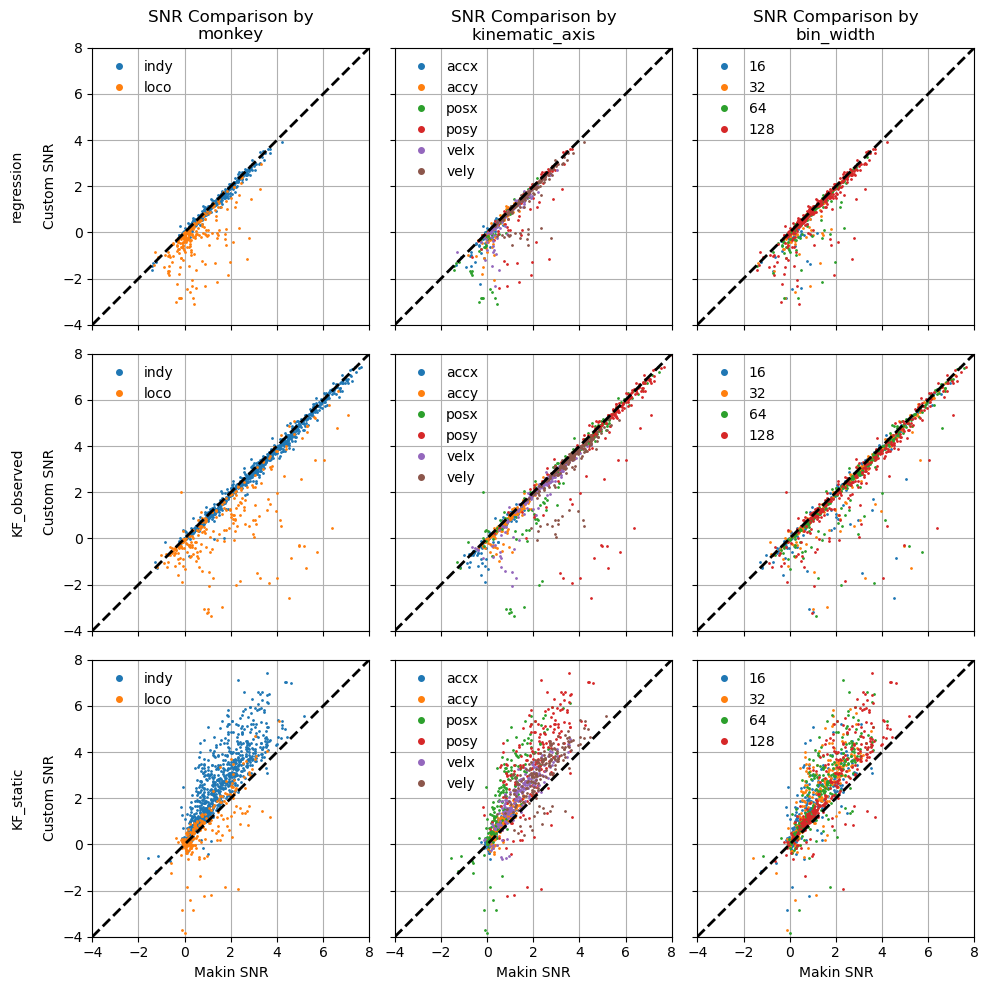

In [34]:
# neural signal decoders implemented in this project
decoders = ["regression", "KF_observed", "KF_static"]

# plot for each decoder, a scatter plot distinguished by
# monkey, bin width, and kinematic axis (hence the 3, below)
f, ax = plt.subplots(len(decoders),3, sharex=True, sharey=True, figsize=(10,10))

# set the axes ranges for the plots (snr)
lowerR = -4
upperR =  8
for i,j in enumerate(decoders):
    if (j == "regression"):
        df_merge = mt.mergeResults(df_makin,df_regress)
    elif (j == "KF_observed"):
        df_merge = mt.mergeResults(df_makin,df_kfObs)
    elif (j == "KF_static"):
        df_merge = mt.mergeResults(df_makin,df_kfStatic)

    # three distinguishable criteria for decoding on sessions
    for k in range(3):
        if (k == 0):
            # get the unique monkeys
            filt_criteria="monkey"
        elif (k == 1):
            # get the unique kinematic axes
            filt_criteria="kinematic_axis"
        elif (k == 2):
            # get the unique bin widths
            filt_criteria="bin_width"
            
        # get the unique objects for filter criteria
        filter = np.unique(df_merge[filt_criteria])

        # plot by filter criteria
        for l,m in enumerate(filter):
            iFilt = np.where(df_merge[filt_criteria] == m)[0]
            ax[i][k].plot(df_merge["snr_ref"].iloc[iFilt],\
                          df_merge["snr"].iloc[iFilt], '.',\
                          ms=2, label=m)

        # plot a 1 for 1 reference line
        # (if results coordinates land on this, they match)
        refLine = np.linspace(lowerR,upperR)
        ax[i][k].plot(refLine, refLine, '--', lw=2, color="black")

        # place axis and title labels
        if (i == 0):
            ax[i][k].set_title("SNR Comparison by\n" + filt_criteria)

        if (k == 0):
            ax[i][k].set_ylabel(j + '\n\nCustom SNR')

        if (i == len(decoders)-1):
            ax[i][k].set_xlabel("Makin SNR")

        # configure plot axes
        ax[i][k].set_xlim(lowerR, upperR)
        ax[i][k].set_ylim(lowerR, upperR)
        ax[i][k].set_aspect('equal', adjustable='box')
        ax[i][k].legend(frameon=False,markerscale=4)
        ax[i][k].grid()

# adjust plots to fit tightly
f.tight_layout()

<font color='gray'>*Figure 4. This plot provides a qualitative assessment for how well the custom implemented decoders match the results for [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) on the same dataset.*</font>

Figure 4 shows a couple points: one, this project was not able to replicate the results for the "loco" monkey and get them to match the baseline [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) results (for this reason, only "indy" sessions will be considered going forward); two, the KF unsupervised with static mapping implemented in this project appears to outperform the baseline implementation.

### Bootstrapping Validation

To quantify the similarity between the regression and KF supervised implementations and by how much the custom KF unsupervised decoder outperforms the baseline implementation, bootstrapping will be performed.

In [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) bootstrapping was performed by re-sampling (with replacement) a new set of SNRs from the original results for all sessions 100,000 times. Each time, the SNR average (or average difference, for comparisons), weighted by the number of samples in a session's evaluation partition, was computed. This returns a distribution of 100,000 SNRs and allows for statistical inference (e.g. stating a statistic with a confidence level). In this project's custom library, a bootstrapping function was made to do this (*bootstrapPrimateDat*). As a test for how well the bootstrapping implementation works, the average SNR performance for [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) main experiment's baseline decoder (regression) is computed. This result was reported in Figure 2 of that paper. This comparison is made in the code below:

In [144]:
kinAx = ["posx","posy","velx","vely","accx","accy"]

# the main experiment in Makin et al., 2018
# compared results for a 64 ms bin size
binWidth = [64] 

# these are the reported results corresponding
# to the kinematic axes in kinAx, respectively
reportedSNR = [0.63,1.51,1.06,1.81,0.09,0.3]

# form print template for results
printTemp = "{0:12}|{1:15}|{2:14}|{3:30}|{4:25}|{5:25}"
# headers
print(printTemp.format("Decoder",\
                       "Kinematic State",\
                       "Bin Width (ms)",\
                       "Makin Reported SNR Avg",\
                       "Computed SNR Avg",\
                       "% Diff SNR Avg"
                      ))

# compute the bootstrap average for each kinematic axis,
# binned at 64 ms for the regression decoder
for k,i in enumerate(kinAx):
    for _,j in enumerate(binWidth):
        res_mk = mt.bootstrapPrimateDat(dfRef=df_makin ,\
                                        statistic="mean",\
                                        decoder="regression",\
                                        monkey="combined",\
                                        bin_width=j, kinAx=i)

        # compute average from the 100,000 weighted bootstrap avgs
        mk_snr_avg = np.average(res_mk.bootstrap_distribution)

        # compute the percent difference in the average from that reported
        pDiffAvg = np.abs((mk_snr_avg-reportedSNR[k])\
                          /np.average([mk_snr_avg, reportedSNR[k]]))*100

        # print the results with the print template
        print(printTemp.format("Regression",\
                               i,\
                               j,\
                               f"{reportedSNR[k]:.4f} dB",\
                               f"{mk_snr_avg:.4f} dB",\
                               f"{pDiffAvg:.2f} %"
                               ))

Decoder     |Kinematic State|Bin Width (ms)|Makin Reported SNR Avg        |Computed SNR Avg         |% Diff SNR Avg           
Regression  |posx           |            64|0.6300 dB                     |0.6238 dB                |0.99 %                   
Regression  |posy           |            64|1.5100 dB                     |1.5336 dB                |1.55 %                   
Regression  |velx           |            64|1.0600 dB                     |1.0540 dB                |0.56 %                   
Regression  |vely           |            64|1.8100 dB                     |1.8268 dB                |0.92 %                   
Regression  |accx           |            64|0.0900 dB                     |0.0889 dB                |1.24 %                   
Regression  |accy           |            64|0.3000 dB                     |0.2967 dB                |1.09 %                   


As can be seen from the results above, the difference in average SNR's computed in this effort from that reported in [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) is less than 2 % for all kinematic axes. Note: there are 2 result files missing from the dataset for another monkey which is not in the [O'Doherty et al., 2020](https://zenodo.org/records/3854034) dataset and could explain the slight difference here.

In the next two code cells below, regression and KF supervised bootstrap results are collected for all bin width and kinematic axis permutations, respectively. The output of the code cells is a table showing the percent difference in average SNR and standard error for the bootstrap distributions between this project and [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95). Also, for the 64 ms bin width case, a plot follows each table overlaying the average SNR bootstrap distributions for each kinematic axis.

### Regression Decoder Implementation Validation

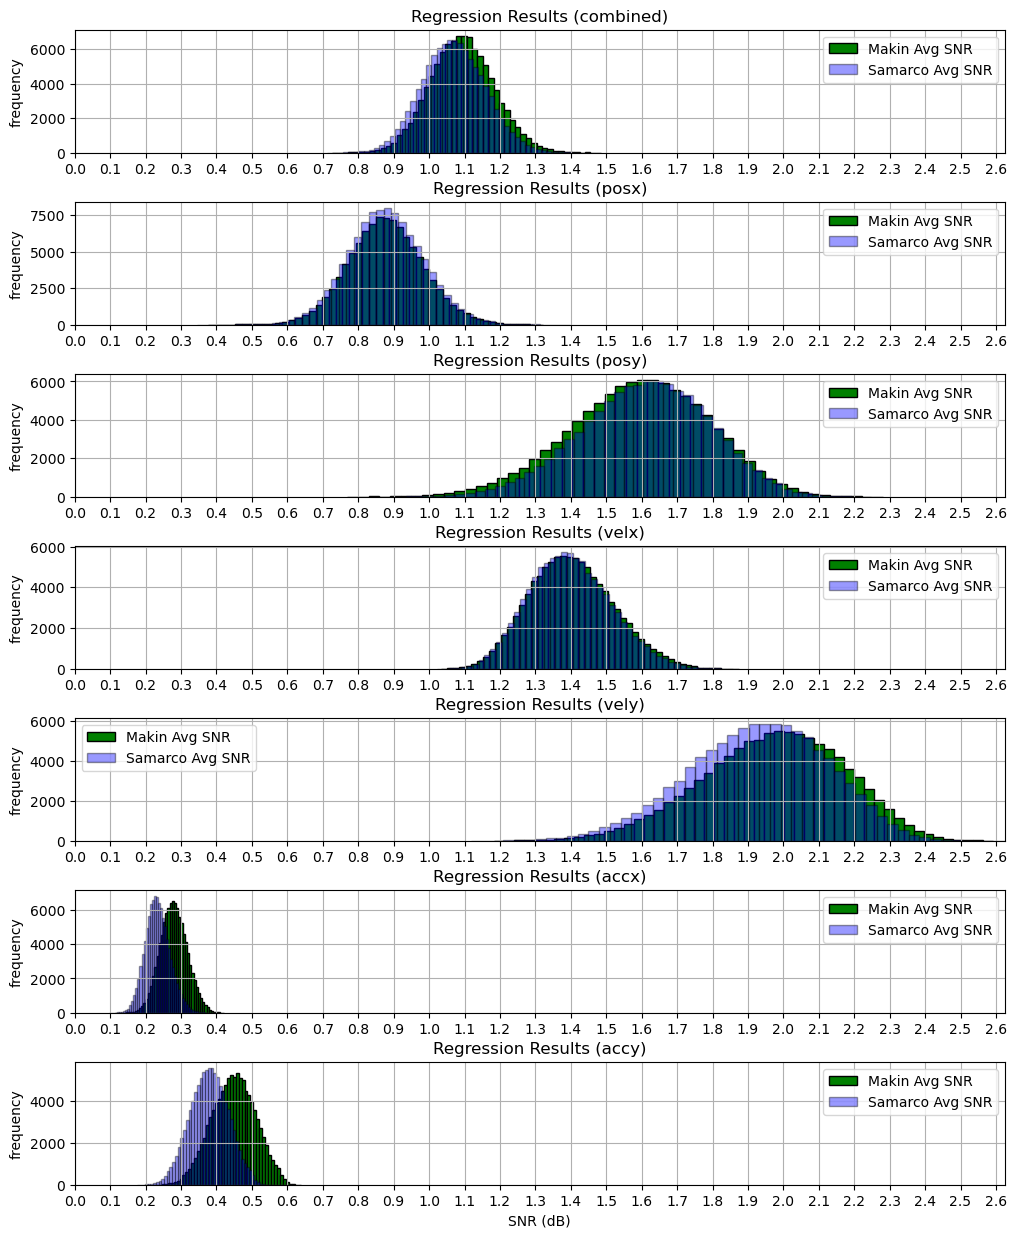

In [731]:
kinAx = ["combined","posx","posy","velx","vely","accx","accy"]
binWidth = ["combined",16,32,64,128]

# plot the 64 ms bin width SNR Average distributions
# between Makin and this Project 
fig, ax = plt.subplots(len(kinAx),1, figsize=(12,15))
maxX = 0
minX = 0

# loop for each kinematic axis and bin width and compute bootstrap statistics
statData = []
for k,i in enumerate(kinAx):
    for _,j in enumerate(binWidth):
        # bootstrap and collect avgs for Makin's (mk)
        # and this projects results (ms)
        res_mk = mt.bootstrapPrimateDat(dfRef=df_makin,\
                                        statistic="mean",\
                                        decoder="regression",\
                                        monkey="indy",\
                                        bin_width=j, kinAx=i)
        res_ms = mt.bootstrapPrimateDat(dfRef=df_regress,\
                                        statistic="mean",\
                                        decoder="regression",\
                                        monkey="indy",\
                                        bin_width=j, kinAx=i)

        # compute sample average from bootstrap distributions        
        mk_snr_avg = np.average(res_mk.bootstrap_distribution)
        ms_snr_avg = np.average(res_ms.bootstrap_distribution)

        # compute percent difference in mk and ms computed average
        pDiffAvg = np.abs((mk_snr_avg-ms_snr_avg)\
                          /np.average([mk_snr_avg, ms_snr_avg]))*100

        # compute percent difference in standard error for mk and ms
        pDiffStdE= np.abs((res_mk.standard_error-\
                           res_ms.standard_error)\
                          /np.average([res_mk.standard_error,\
                                       res_ms.standard_error]))*100

        # collect statistical results for printing
        statData.append([   "regress",\
                            i,\
                            j,\
                            f"{mk_snr_avg:8.4f} dB",\
                            f"{ms_snr_avg:8.4f} dB",\
                            f"{pDiffAvg:6.2f} %",\
                            f"{res_mk.standard_error:8.4f} dB",\
                            f"{res_ms.standard_error:8.4f} dB",\
                            f"{pDiffStdE:6.2f} %"])

        # plot the 64 ms binned bootstrap SNR avg distributions
        if (j == 64):
    
            if (len(kinAx) <= 1):
                pAx = ax
            else:
                pAx = ax[k]
                
            h1 = pAx.hist(res_mk.bootstrap_distribution,\
                          bins=50, color="green",\
                          edgecolor="black",\
                          label="Makin Avg SNR")
            h2 = pAx.hist(res_ms.bootstrap_distribution,\
                          bins=50, color="blue",\
                          edgecolor="black", alpha=0.4,\
                          label="Samarco Avg SNR")

            # retain mins and max's for lims
            maxX = max([maxX, max(h1[1]), max(h2[1])])
            minX = min([minX, min(h1[1]), min(h2[1])])
            pAx.set_title('Regression Results (' + f"{i})")
            if (k == (len(kinAx)-1)):
                pAx.set_xlabel('SNR (dB)')
            pAx.set_ylabel('frequency')
        
            pAx.grid()
            pAx.legend()

for i in ax:
    i.set_xlim([minX,maxX])
    i.set_xticks(np.arange(minX,maxX,0.1))

plt.subplots_adjust(hspace = 0.4)
plt.show()

# put statistical results in a df 
dfReg_res = pd.DataFrame(statData, columns=[    "Decoder",\
                                                "KinState",\
                                                "Bin (ms)",\
                                                "Makin SNR Avg.",\
                                                "Samarco SNR Avg",\
                                                "% Diff SNR Avg",\
                                                "Makin SNR Std Err",\
                                                "MS SNR Std Err",\
                                                "% Diff Std Err"])

<font color='gray'>*Figure 5. This plot shows a comparison for the avg SNR bootstrap distributions for [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) and this Project's results (Samarco) on the same dataset for the regression decoder. For mostly all axes, the two distributions align very nicely. The average SNR acceleration distributions look to have similar standard error but differ somewhat in overall average.*</font>

In [732]:
i_combo = np.where(dfReg_res["Bin (ms)"] == "combined")[0]
dfReg_res.iloc[i_combo]

Decoder  KinState  Bin (ms) Makin SNR Avg. Samarco SNR Avg % Diff SNR Avg Makin SNR Std Err MS SNR Std Err % Diff Std Err
0   regress  combined  combined      0.6985 dB       0.6892 dB         1.33 %         0.0371 dB      0.0372 dB         0.35 %
5   regress      posx  combined      0.4825 dB       0.4863 dB         0.79 %         0.0548 dB      0.0554 dB         1.19 %
10  regress      posy  combined      0.9992 dB       1.0070 dB         0.78 %         0.0924 dB      0.0913 dB         1.16 %
15  regress      velx  combined      0.9180 dB       0.9117 dB         0.68 %         0.0646 dB      0.0627 dB         2.88 %
20  regress      vely  combined      1.3349 dB       1.3138 dB         1.59 %         0.0992 dB      0.0977 dB         1.54 %
25  regress      accx  combined      0.1808 dB       0.1606 dB        11.87 %         0.0169 dB      0.0157 dB         7.34 %
30  regress      accy  combined      0.2925 dB       0.2722 dB         7.20 %         0.0221 dB      0.0210 dB         5.23 %

As evident in the table and plots above for the regression decoder, the implementation in this project matches its reference fairly well (<1% difference in SNR average performance for all kinematic states, aside from acceleration, when considering all bin width results). Acceleration predictions are least accurate with 7-12% difference in SNR average performance, suggesting a difference in implementation here for acceleration computation.

### KF Supervised Decoder Implementation Validation

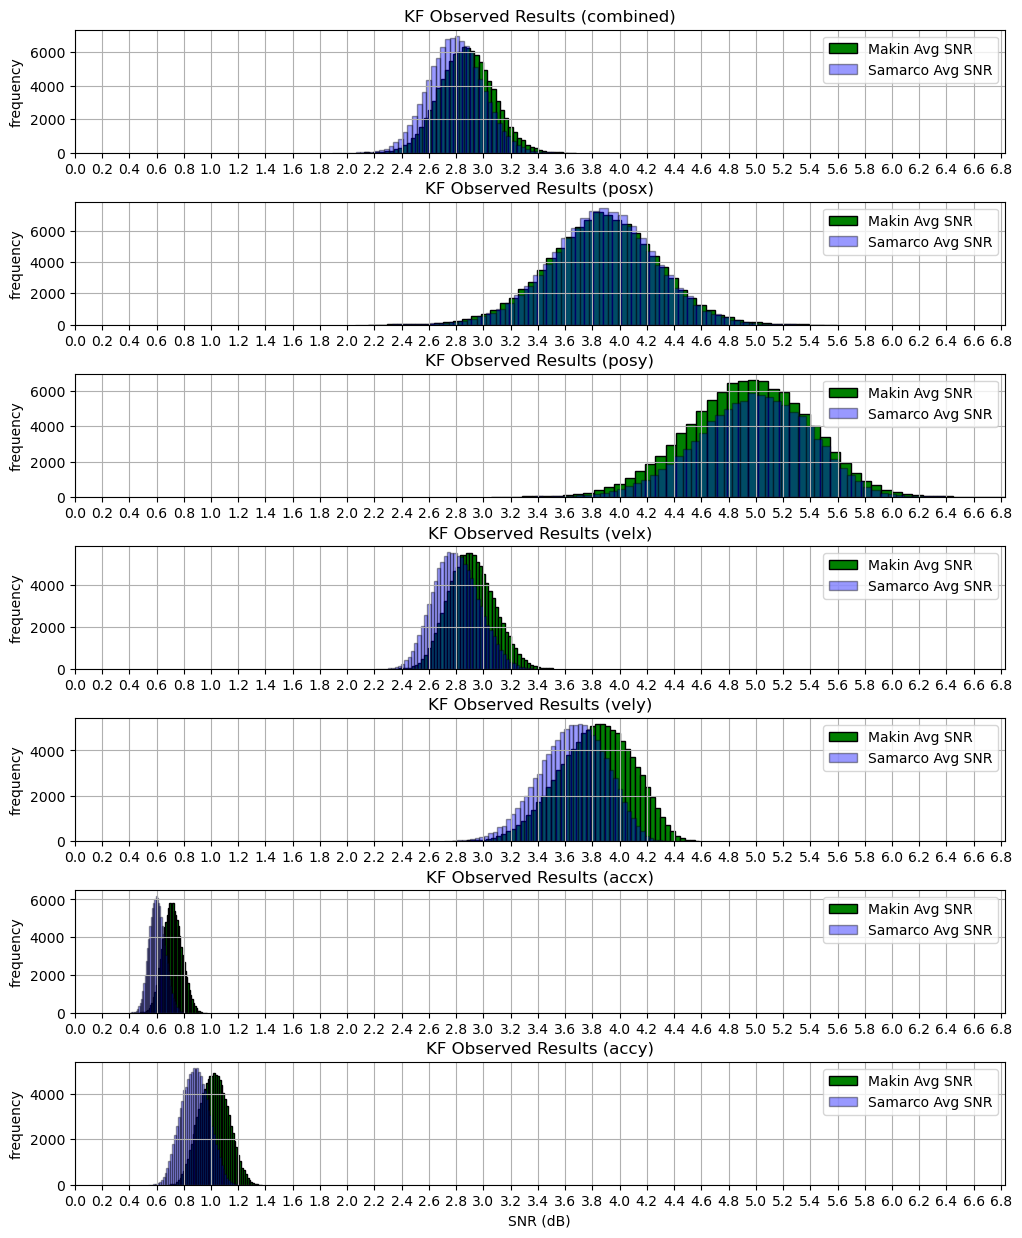

In [721]:
kinAx = ["combined","posx","posy","velx","vely","accx","accy"]
binWidth = ["combined",16,32,64,128]

# plot the 64 ms bin width SNR Average distributions
# between Makin and this Project 
fig, ax = plt.subplots(len(kinAx),1, figsize=(12,15))
maxX = 0
minX = 0

# loop for each kinematic axis and bin width and compute bootstrap statistics
statData = []
for k,i in enumerate(kinAx):
    for _,j in enumerate(binWidth):
        # bootstrap and collect avgs for Makin's (mk)
        # and this projects results (ms)
        res_mk = mt.bootstrapPrimateDat(dfRef=df_makin,\
                                        statistic="mean",\
                                        decoder="KF_observed",\
                                        monkey="indy",\
                                        bin_width=j, kinAx=i)
        res_ms = mt.bootstrapPrimateDat(dfRef=df_kfObs,\
                                        statistic="mean",\
                                        decoder="KF_observed",\
                                        monkey="indy",\
                                        bin_width=j, kinAx=i)

        # compute sample average from bootstrap distributions
        mk_snr_avg = np.average(res_mk.bootstrap_distribution)
        ms_snr_avg = np.average(res_ms.bootstrap_distribution)

        # compute percent difference in mk and ms computed average
        pDiffAvg = np.abs((mk_snr_avg-ms_snr_avg)\
                          /np.average([mk_snr_avg, ms_snr_avg]))*100

        # compute percent difference in standard error for mk and ms
        pDiffStdE= np.abs((res_mk.standard_error-\
                           res_ms.standard_error)\
                          /np.average([res_mk.standard_error,\
                                       res_ms.standard_error]))*100

        # collect statistical results for printing
        statData.append([   "KFObs",\
                            i,\
                            j,\
                            f"{mk_snr_avg:8.4f} dB",\
                            f"{ms_snr_avg:8.4f} dB",\
                            f"{pDiffAvg:6.2f} %",\
                            f"{res_mk.standard_error:8.4f} dB",\
                            f"{res_ms.standard_error:8.4f} dB",\
                            f"{pDiffStdE:6.2f} %"])

        # plot the 64 ms binned bootstrap SNR avg distributions
        if (j == 64):
            if (len(kinAx) <= 1):
                pAx = ax
            else:
                pAx = ax[k]
            h1 = pAx.hist(res_mk.bootstrap_distribution,\
                          bins=50, color="green",\
                          edgecolor="black", label="Makin Avg SNR")
            h2 = pAx.hist(res_ms.bootstrap_distribution,\
                          bins=50, color="blue",\
                          edgecolor="black", alpha=0.4,\
                          label="Samarco Avg SNR")
            maxX = max([maxX, max(h1[1]), max(h2[1])])
            minX = min([minX, min(h1[1]), min(h2[1])])
            pAx.set_title('KF Observed Results (' + f"{i})")
            if (k == (len(kinAx)-1)):
                pAx.set_xlabel('SNR (dB)')
            pAx.set_ylabel('frequency')
        
            pAx.grid()
            pAx.legend()

for i in ax:
    i.set_xlim([minX,maxX])
    i.set_xticks(np.arange(minX,maxX,0.2))

plt.subplots_adjust(hspace = 0.4)
plt.show()

# put statistical results in a df 
dfKfObs_res = pd.DataFrame(statData, columns=[ "Decoder",\
                                                "KinState",\
                                                "Bin (ms)",\
                                                "Makin SNR Avg.",\
                                                "Samarco SNR Avg",\
                                                "% Diff SNR Avg",\
                                                "Makin SNR Std Err",\
                                                "MS SNR Std Err",\
                                                "% Diff Std Err"])

<font color='gray'>*Figure 6. This plot shows a comparison for the avg SNR bootstrap distributions for [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) and this Project's results (Samarco) on the same dataset for the KF supervised decoder. All distributions, aside acceleration, agree/align very nicely.*</font>

In [728]:
i_combo = np.where(dfKfObs_res["Bin (ms)"] == "combined")[0]
dfKfObs_res.iloc[i_combo]

Decoder  KinState  Bin (ms) Makin SNR Avg. Samarco SNR Avg % Diff SNR Avg Makin SNR Std Err MS SNR Std Err % Diff Std Err
0    KFObs  combined  combined      2.4480 dB       2.3986 dB         2.04 %         0.1204 dB      0.1194 dB         0.81 %
5    KFObs      posx  combined      3.5675 dB       3.5237 dB         1.24 %         0.2406 dB      0.2336 dB         2.99 %
10   KFObs      posy  combined      4.4497 dB       4.3943 dB         1.25 %         0.2035 dB      0.2158 dB         5.83 %
15   KFObs      velx  combined      2.4713 dB       2.4334 dB         1.55 %         0.1012 dB      0.0990 dB         2.16 %
20   KFObs      vely  combined      3.3069 dB       3.2312 dB         2.32 %         0.1471 dB      0.1416 dB         3.77 %
25   KFObs      accx  combined      0.3260 dB       0.2930 dB        10.66 %         0.0607 dB      0.0549 dB        10.09 %
30   KFObs      accy  combined      0.5937 dB       0.5428 dB         8.95 %         0.0631 dB      0.0626 dB         0.76 %

As evident in the table and plots above for the KF supervised decoder the implementation in this project matches its reference fairly well (~2 % difference in average SNR for the decoders when considering all bin widths and kinematic states). Acceleration predictions are least accurate with 9-11% difference in SNR average performance, suggesting a difference in implementation here for acceleration computation.

### KF Unsupervised Decoder Implementation Validation

Now, as evident in figure 4, the decoder implemented here for the KF Unsupervised with static mapping performs better than the reference implementation by [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95). What is left is to quantify by how much the expected performance improvement is for this project's implementation. The code below will collect bootstrap results for average SNR performances between the two KF unsupervised with static mapping implementations. It will also get the average difference in SNR performance among the implementations and compute the percent improvement from the Makin reference result at the 95% confidence level (p>0.05).

Additionally, since a large increase in SNR performance was observed for this project's KF unsupervised, it will be plotted against other Makin KF variants under a specific case of 64ms binning and for each kinematic state. This will give a sense of if the increase in performance pushes this decoder to a level that is similar to that demonstrated by the KF supervised and KF unsupervised with dynamic mapping decoders.

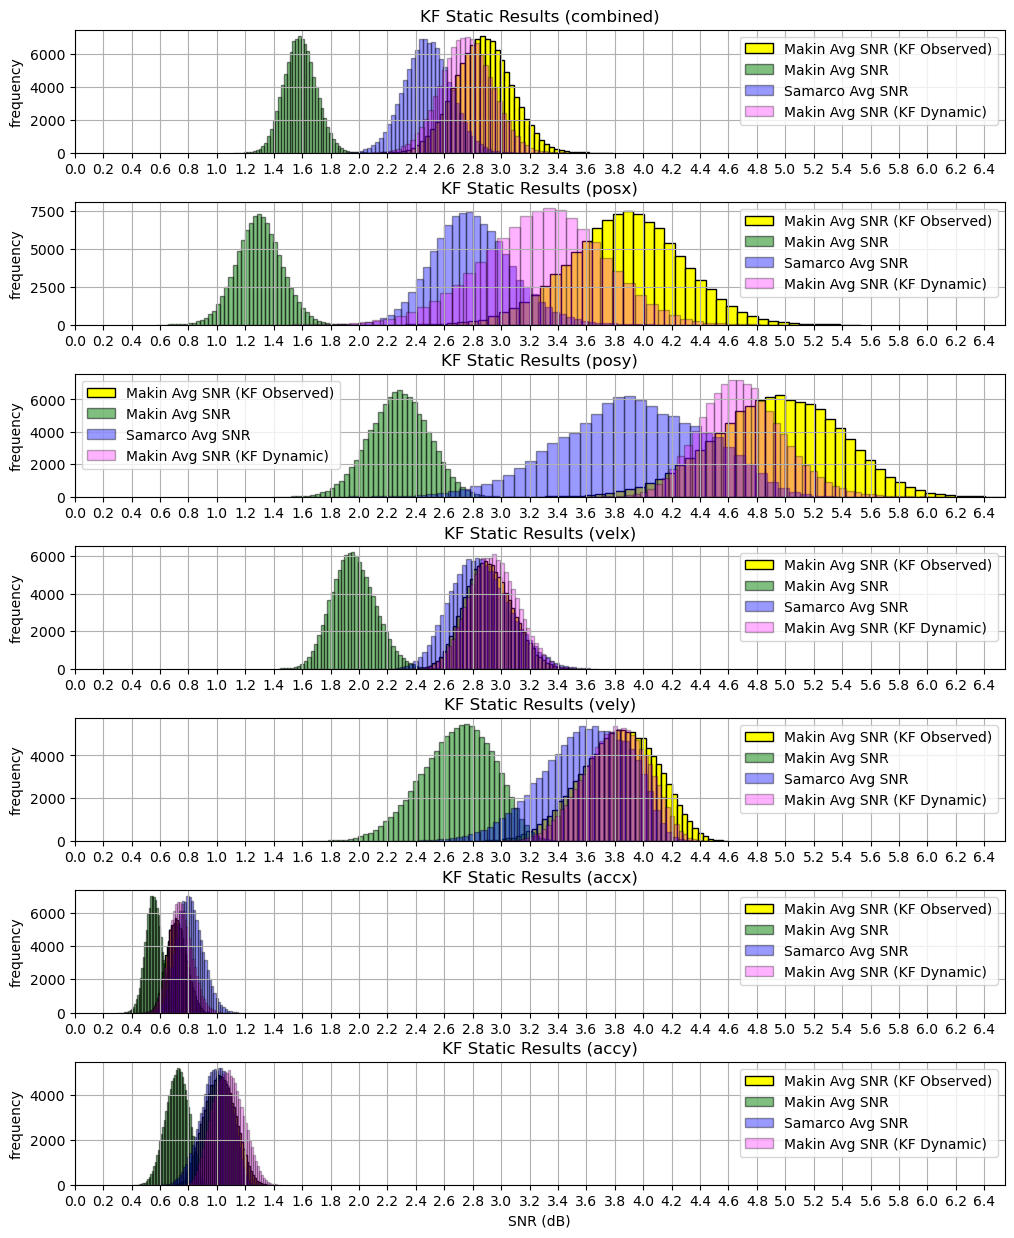

In [685]:
kinAx = ["combined","posx","posy","velx","vely","accx","accy"]
binWidth = ["combined",16,32,64,128]

# plot the 64 ms bin width SNR Average distributions
# between Makin and this Project 
fig, ax = plt.subplots(len(kinAx),1, figsize=(12,15))
maxX = 0
minX = 0

# loop for each kinematic axis and bin width and compute bootstrap statistics
statData = []
for k,i in enumerate(kinAx):
    for _,j in enumerate(binWidth):
        # bootstrap and collect avgs for Makin's (mk)
        # and this projects results (ms)

        # this bootstrap is for finding the distribution
        # of the Makin KF Static SNR averages
        res_mk = mt.bootstrapPrimateDat(dfRef=df_makin, statistic="mean",\
                                        decoder="KF_static", monkey="indy",\
                                        bin_width=j, kinAx=i)

        # this bootstrap will find the distribution
        # of the average SNR differences between Makin and this project's
        # KF Static decoder
        res_diff = mt.bootstrapPrimateDat(dfRef=df_makin,dfDat2=df_kfStatic,\
                                          statistic="mean_diff",\
                                          decoder="KF_static",\
                                          monkey="indy", bin_width=j,\
                                          kinAx=i, cLev=0.90)

        # compute the average for the baseline (Makin)
        res_mk_snr_avg   = np.average(res_mk.bootstrap_distribution)

        # compute the average difference in decoder implementation
        # (this project and baseline)
        res_diff_snr_avg = np.average(res_diff.bootstrap_distribution)
    
        # compute the percent increase at 95% level
        # to average of Makin et al., 2018's results

        # desired p level for avg SNR difference of implementations
        desired_p = 0.05
        # number of bootstraps
        N_bootstrap = len(res_diff.bootstrap_distribution)
        hist, bin_edges = np.histogram(res_diff.bootstrap_distribution,1000)
        i_p = np.where(np.cumsum(hist)/N_bootstrap >= desired_p)[0][0]
        snr_p = bin_edges[i_p] # the snr difference at the desired p level

        # actual p level for the snr difference found at a p level targeted
        # for the desired
        # (most likely the desired p, but could be slightly different)
        actual_p = 1-len(np.where(res_diff.bootstrap_distribution >=\
                                  snr_p)[0])/N_bootstrap

        # compute the percent increase in this project's KF static decoder
        # from Makin's average SNR for the same decoder at the p level.
        perIncSnr_p = snr_p/res_mk_snr_avg*100

        # collect statistical results for printing
        statData.append([   "KFStat",\
                            i,\
                            j,\
                            f"{res_diff_snr_avg:8.4f} dB",\
                            f"{res_diff.standard_error:8.5f} dB",\
                            f"{snr_p:8.4f} dB (p > {actual_p:4.2f})",\
                            f"{perIncSnr_p:8.2f} % (p > {actual_p:4.2f})"])

        # plot the distributions of average SNRs for a 64 ms bin width
        if (j == 64):
            # this is the bootstrap distribution of SNR averages for
            # Makin's KF observed decoder
            res_mk_kfObs = mt.bootstrapPrimateDat(dfRef=df_makin,\
                                                  statistic="mean",\
                                                  decoder="KF_observed",\
                                                  monkey="indy",\
                                                  bin_width=j, kinAx=i)

            # this is the bootstrap distribution of SNR averages for
            # Makin's KF unsupervised with dynamic mapping decoder
            res_mk_kfDyn = mt.bootstrapPrimateDat(dfRef=df_makin,\
                                                  statistic="mean",\
                                                  decoder="KF_dynamic",\
                                                  monkey="indy",\
                                                  bin_width=j, kinAx=i)

            # this is the bootstrap distribution of SNR averages for
            # this project's KF unsupervised decoder with static mapping
            res_ms = mt.bootstrapPrimateDat(dfRef=df_kfStatic,\
                                            statistic="mean",\
                                            decoder="KF_static",\
                                            monkey="indy",\
                                            bin_width=j, kinAx=i)

            if (len(kinAx) <= 1):
                pAx = ax
            else:
                pAx = ax[k]
            h1 = pAx.hist(res_mk_kfObs.bootstrap_distribution,\
                          bins=50, color="yellow",\
                          edgecolor="black",\
                          label="Makin Avg SNR (KF Observed)")
            h2 = pAx.hist(res_mk.bootstrap_distribution, bins=50,\
                          color="green", edgecolor="black", alpha=0.5,\
                          label="Makin Avg SNR")
            h3 = pAx.hist(res_ms.bootstrap_distribution, bins=50,\
                          color="blue", edgecolor="black", alpha=0.4,\
                          label="Samarco Avg SNR")
            h4 = pAx.hist(res_mk_kfDyn.bootstrap_distribution, bins=50,\
                          color="magenta", edgecolor="black", alpha=0.3,\
                          label="Makin Avg SNR (KF Dynamic)")
            maxX = max([maxX, max(h1[1]), max(h2[1]),\
                        max(h3[1]), max(h4[1])])
            minX = min([minX, min(h1[1]), min(h2[1]),\
                        min(h3[1]), min(h4[1])])
            pAx.set_title('KF Static Results (' + f"{i})")
            if (k == (len(kinAx)-1)):
                pAx.set_xlabel('SNR (dB)')
            pAx.set_ylabel('frequency')
        
            pAx.grid()
            pAx.legend()

for i in ax:
    i.set_xlim([minX,maxX])
    i.set_xticks(np.arange(minX,maxX,0.2))

plt.subplots_adjust(hspace = 0.4)
plt.show()

# put statistical results in a df 
dfKfStat_res = pd.DataFrame(statData, columns=[ "Decoder",\
                                                "KinState",\
                                                "Bin (ms)",\
                                                "SNR Avg Increase",\
                                                "STDerr SNR Avg Increase",\
                                                "SNR Increase > (p)",\
                                                "%Inc SNR from Makin Avg (p)"])

<font color='gray'>*Figure 7. This plot shows a comparison for the avg SNR bootstrap distributions for the different [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) KF decoders and this Project's KF unsupervised decoder with static mapping (Samarco) on the same dataset for a 64 ms bin size. The green and blue plot show the distributions for both implementations of the same type, or KF unsupervised decoder with static mapping. As evident here, this project's implementation of a KF unsupervised decoder with static mapping outperforms the baseline result and appears to have performances close to the other KF decoders (supervised and unsupervised with dynamic [KF] mapping to actual kinematic states).*</font>

#### KF Unsupervised Performance Increase at the 95% Confidence Level

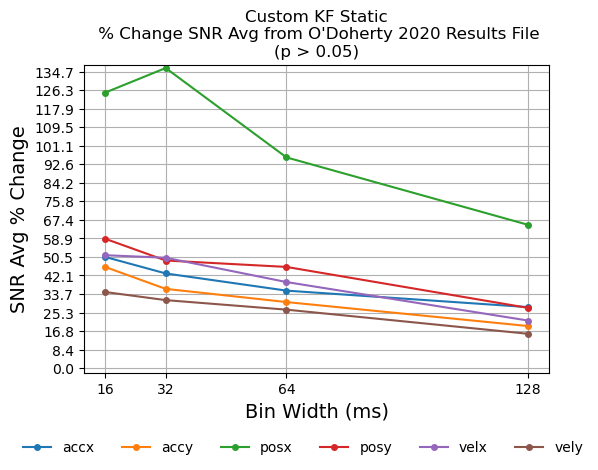

In [718]:
f, ax = plt.subplots(1,sharex=True, figsize=(6,4))


minR = 0
maxR = 0
for k in np.unique(dfKfStat_res["KinState"]):
    if (k != "combined"):
        df_dec_kAx = dfKfStat_res.iloc[np.where(dfKfStat_res["KinState"] == k)[0]]
    
        snr_change_str = df_dec_kAx["%Inc SNR from Makin Avg (p)"].to_string(index=False).split(" % (p > 0.05)\n")
        snr_change_str[-1] = snr_change_str[-1].split(" % (p > 0.05)")[0]
        snr_change_per = [float(s) for s in snr_change_str[1:]] # skip "combined" or 0-th index

        minR = min([minR, round(min(snr_change_per))])
        maxR = max([maxR, round(max(snr_change_per))])
    
        ax.plot(df_dec_kAx["Bin (ms)"].iloc[1:], (snr_change_per), '.-', ms=8, label=k)

ax.set_xticks(np.unique(df_dec_kAx["Bin (ms)"].iloc[1:]).astype("int"))
ax.grid(which="minor")
ax.grid(which="major")
ax.set_yticks(np.linspace(round(minR,-1),round(maxR,-1)+20,20))
ax.set_ylim([minR-2,maxR+2])
ax.set_xlabel("Bin Width (ms)", fontsize=14);
ax.set_title("Custom KF Static\n % Change SNR Avg from O'Doherty 2020 Results File\n(p > 0.05)")

ax.set_ylabel("SNR Avg % Change", fontsize=14)
ax.legend(frameon=False, ncols=6, bbox_to_anchor=(1.1, -0.18))
plt.subplots_adjust(wspace=0.21)

<font color='gray'>*Figure 8. This plot shows the percent increase in the avg SNR for this project's KF static decoder when compared to the reference decoder by [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95). The plot reports the SNR average performance gain at the 95% confidence level (p>0.05) for all kinematics and bin widths tested.*</font>

As can be seen in the results plots above, the KF static decoder implemented in this project performs greater than the [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) implementation on the same dataset when considering any kinematic state for any of the bin widths used in this project ($p>0.05$). Also, the 64ms distribution plots (figure 7) indicate that the KF static implementation in this project may outperform or perform similarly to Makin's KF supervised and KF unsupervised with dynamic mapping implementation for velocity and acceleration.

## Get Multi-Unit Results

Like figure 4, a scatter plot is plotted here as well. This scatter plot is made up of points that have coordinates (SU SNR, MU SNR) to gauge the difference between using MU and SU on the decoders among all session results processed for the "Indy" monkey at all bin width and all kinematics.

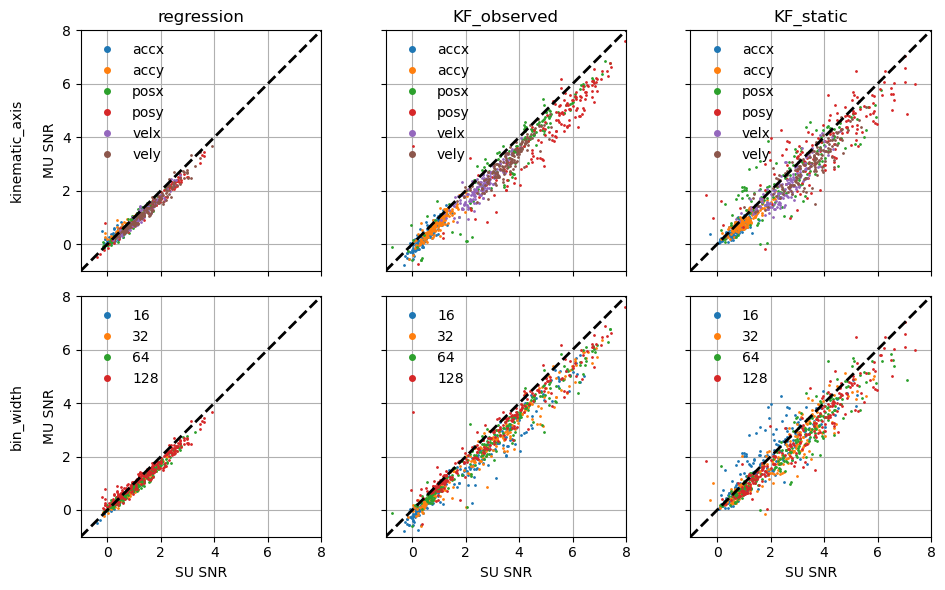

In [36]:
# neural signal decoders implemented in this project
decoders = ["regression", "KF_observed", "KF_static"]

# plot for each decoder, a scatter plot distinguished by
# bin width, and kinematic axis (hence the 2, below)
f, ax = plt.subplots(2,len(decoders), sharex=True, sharey=True,\
                     figsize=(10,6))

# set the axes ranges for the plots (snr)
lowerR = -1
upperR =  8
for i,j in enumerate(decoders):
    if (j == "regression"):
        df_merge = mt.mergeResults(df_regress,df_regressMU)
    elif (j == "KF_observed"):
        df_merge = mt.mergeResults(df_kfObs,df_kfObsMU)
    elif (j == "KF_static"):
        df_merge = mt.mergeResults(df_kfStatic,df_kfStaticMU)

    # two distinguishable criteria for decoding on sessions
    for k in range(2):
        if (k == 0):
            # get the unique kinematic axes
            filt_criteria="kinematic_axis"
        elif (k == 1):
            # get the unique bin widths
            filt_criteria="bin_width"
            
        # get the unique objects for filter criteria
        filter = np.unique(df_merge[filt_criteria])

        # plot by filter criteria
        for l,m in enumerate(filter):
            iFilt = np.where(df_merge[filt_criteria] == m)[0]
            
            # only look at indy
            jFilt = np.where(df_merge["monkey"].iloc[iFilt] == "indy")[0]
            ax[k][i].plot(df_merge["snr_ref"].iloc[iFilt].iloc[jFilt],\
                          df_merge["snr"].iloc[iFilt].iloc[jFilt], '.',\
                          ms=2, label=m)

        # plot a 1 for 1 reference line
        # (if results coordinates land on this, they match)
        refLine = np.linspace(lowerR,upperR)
        ax[k][i].plot(refLine, refLine, '--', lw=2, color="black")

        # place axis and title labels
        if (k == 0):
            ax[k][i].set_title(j)

        if (i == 0):
            ax[k][i].set_ylabel(filt_criteria + '\n\nMU SNR')

        if (k == 1):
            ax[k][i].set_xlabel("SU SNR")

        # configure plot axes
        ax[k][i].set_xlim(lowerR, upperR)
        ax[k][i].set_ylim(lowerR, upperR)
        ax[k][i].set_aspect('equal', adjustable='box')
        ax[k][i].legend(frameon=False,markerscale=4)
        ax[k][i].grid()

# adjust plots to fit tightly
f.tight_layout()

<font color='gray'>*Figure 9. This plot shows a comparison for the SNR computed for each session, bin width, and kinematic axis combination for the "indy" monkey for the three decoders implemented in this project. The SU data looks to be superior across plots.*</font>

### Multi-Unit vs. Single Unit Quantification

The code that follows collects quantitative results for SU and MU comparison for all permutations of kinematic axis, bin width, and decoder (implemented in this project) for the "indy" session data. The results collected are found from generating 100,000 sample bootstrap distribution on the custom decoders and are as follows:

* SU SNR Average performance
* MU SNR Average performance
* The average SNR change resulting in going from SU to MU data for a decoder
* The average SNR change resulting in going from SU to MU data for a decoder at the p > ~0.15 level
* Percent change in average SNR when going from SU to MU from the average SNR for SU at the p > ~0.15 level

In [612]:
kinAx    = ["combined","posx","posy","velx","vely","accx","accy"]
binWidth = ["combined",16,32,64,128]
decoder  = ["regression", "KF_observed", "KF_static"]

# loop and print results for each decoder, for all permutations of
# bin width and kinematic state for the "indy" monkey
statData = []
for _,i in enumerate(decoder):
    if (i == "regression"):
        d = "regress"
        dfRef = df_regress.copy()   # SU results
        dfComp= df_regressMU.copy() # MU results
    elif (i == "KF_observed"):
        d = "KFObs"
        dfRef = df_kfObs.copy()
        dfComp= df_kfObsMU.copy()
    elif (i == "KF_static"):
        d = "KFStat"
        dfRef = df_kfStatic.copy()
        dfComp= df_kfStaticMU.copy()

    for _,j in enumerate(kinAx):
        for _,k in enumerate(binWidth):
            # this bootstrapping is the distribution of
            # average SNR for the SU data
            res_ref = mt.bootstrapPrimateDat(dfRef=dfRef, statistic="mean",\
                                            decoder=i, monkey="indy",\
                                            bin_width=k, kinAx=j)

            # this bootstrapping is the distribution of
            # average SNR for the MU data
            res_mu  = mt.bootstrapPrimateDat(dfRef=dfComp, statistic="mean",\
                                            decoder=i, monkey="indy",\
                                            bin_width=k, kinAx=j)

            # this bootstrapping is the distribution of
            # difference in average SNR between the SU and MU data
            res_diff = mt.bootstrapPrimateDat(dfRef=dfRef, dfDat2=dfComp,\
                                              statistic="mean_diff",\
                                              decoder=i, monkey="indy",\
                                              bin_width=k, kinAx=j,\
                                              cLev=0.90)

            # get average SNR for SU, MU, and their difference
            res_ref_snr_avg  = np.average(res_ref.bootstrap_distribution)
            res_mu_snr_avg   = np.average(res_mu.bootstrap_distribution)
            res_diff_snr_avg = np.average(res_diff.bootstrap_distribution)
        
            # percent change (SU->MU) from 1-p level to average
            # of SU performance
            desired_p = 0.15
            N_bootstrap = len(res_diff.bootstrap_distribution)
            hist, bin_edges = np.histogram(res_diff.bootstrap_distribution,\
                                           1000)
            i_p = np.where(np.cumsum(hist)/N_bootstrap >= desired_p)[0][0]

            # the snr difference at the desired p level
            snr_p = bin_edges[i_p]

            # actual p level for the snr difference found at
            # a p level targeted for the desired
            # (most likely the desired p, but could be slightly different)
            actual_p = 1-len(np.where(res_diff.bootstrap_distribution >=\
                                      snr_p)[0])/N_bootstrap

            # compute the percent increase in this project's
            # KF static decoder from Makin's average SNR
            # for the same decoder at the p level.
            perIncSnr_p = snr_p/res_ref_snr_avg*100

            # collect statistical results for printing
            statData.append([   d,\
                                j,\
                                k,\
                                f"{res_ref_snr_avg:8.4f} dB",\
                                f"{res_mu_snr_avg:8.4f} dB",\
                                f"{res_diff_snr_avg:8.4f} dB",\
                                f"{snr_p:8.4f} dB(p > {actual_p:4.2f})",\
                                f"{perIncSnr_p:8.2f} %(p > {actual_p:4.2f})"])

# put statistical results in a df 
dfmu_res = pd.DataFrame(statData, columns=["Decoder",\
                                            "KinState",\
                                            "Bin (ms)",\
                                            "SU SNR Avg",\
                                            "MU SNR Avg",\
                                            "SNR Avg Change (SU->MU)",\
                                            "SNR Change > (p)",\
                                            "%Change SNR from SU Avg (p)"])

#### MU SNR Avg % Change from SU Avg at 85% Confidence Level

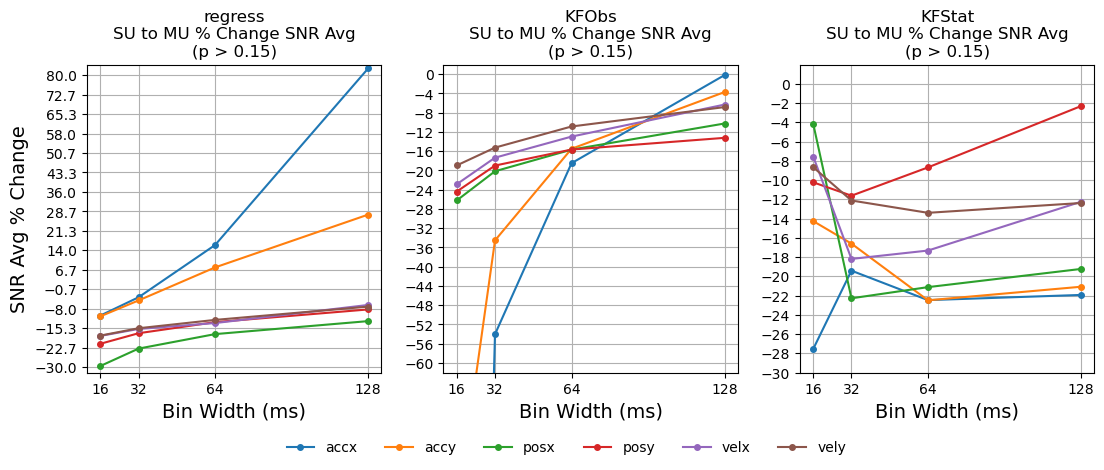

In [613]:
f, ax = plt.subplots(1,3, sharex=True, figsize=(13,4))

for i,j in enumerate(["regress", "KFObs", "KFStat"]):
    # get dfmu_res by decoder
    df_dec = dfmu_res.iloc[np.where(dfmu_res["Decoder"] == j)[0]]
    
    # drop combined kinematic axes and bin width results
    df_dec.drop(index=df_dec.iloc[np.where(df_dec["Bin (ms)"] == "combined")[0]].index.tolist(), inplace=True)
    df_dec.drop(index=df_dec.iloc[np.where(df_dec["KinState"] == "combined")[0]].index.tolist(), inplace=True)

    minR = 0
    maxR = 0
    for k in np.unique(df_dec["KinState"]):
        df_dec_kAx = df_dec.iloc[np.where(df_dec["KinState"] == k)[0]]
    
        snr_change_str = df_dec_kAx["%Change SNR from SU Avg (p)"].to_string(index=False).split(" %(p > 0.15)\n")
        snr_change_str[-1] = snr_change_str[-1].split(" %(p > 0.15)")[0]
        snr_change_per = [float(s) for s in snr_change_str]

        minR = min([minR, round(min(snr_change_per))])
        maxR = max([maxR, round(max(snr_change_per))])
    
        ax[i].plot(df_dec_kAx["Bin (ms)"], (snr_change_per), '.-', ms=8, label=k)

    if (minR < -60):
        minR = -60

    if (maxR > 100):
        maxR = 100

    ax[i].set_xticks(np.unique(df_dec_kAx["Bin (ms)"]).astype("int"))
    ax[i].grid(which="minor")
    ax[i].grid(which="major")
    ax[i].set_yticks(np.linspace(round(minR,-1),round(maxR,-1),16))
    ax[i].set_ylim([minR-2,maxR+2])
    ax[i].set_xlabel("Bin Width (ms)", fontsize=14);
    ax[i].set_title(j + "\nSU to MU % Change SNR Avg\n(p > 0.15)")

ax[0].set_ylabel("SNR Avg % Change", fontsize=14)
ax[-1].legend(frameon=False, ncols=6, bbox_to_anchor=(0.2, -0.18))
plt.subplots_adjust(wspace=0.21)

<font color='gray'>*Figure 10. This plot shows the percent change in the avg SNR for all decoders implemented when decoding single-unit neural data vs. multi-unit neural data. The plot reports this SNR average change at a 85% confidence level (p>0.15) for all kinematics and bin widths tested.*</font>

## Get Results for Dropping Spikes

The code below will plot scatter plots for the case of dropping 5%, 15%, 25%, and 50% of spikes from the neural observational data. The x-coordinate for the data points will be the reference, or the case for no spikes dropped.

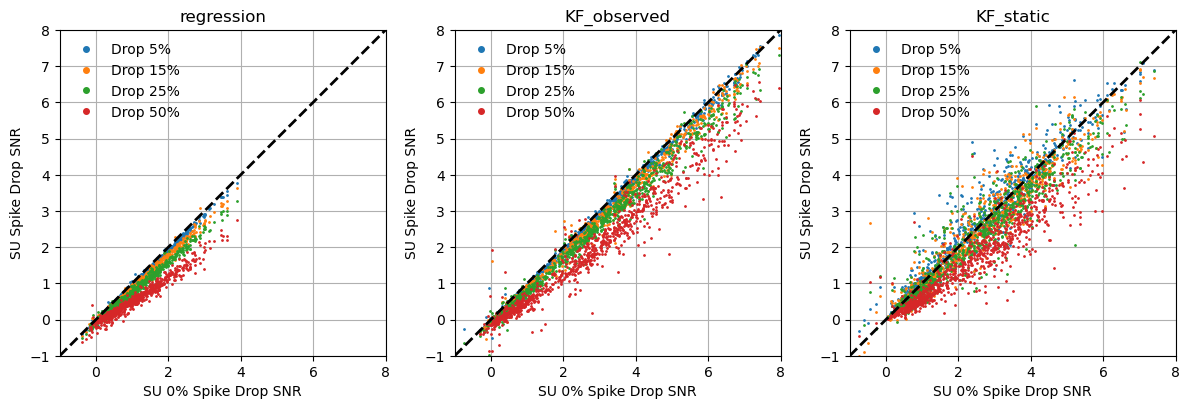

In [742]:
# neural signal decoders implemented in this project
decoders = ["regression", "KF_observed", "KF_static"]

# percentage of neural spikes dropped for decoder testing
dropSpksPer = [5, 15, 25, 50]

# plot for each decoder, a scatter plot distinguished by
# percentage of dropped spikes
f, ax = plt.subplots(1,len(decoders), figsize=(12,6))

# set the axes ranges for the plots (snr)
lowerR = -1
upperR =  8
for i,j in enumerate(decoders):
    for k,l in enumerate(dropSpksPer):
        if (j == "regression"):
            if (l == 5):
                df_merge = mt.mergeResults(df_regress,df_regressD05)
            elif (l == 15):
                df_merge = mt.mergeResults(df_regress,df_regressD15)
            elif (l == 25):
                df_merge = mt.mergeResults(df_regress,df_regressD25)
            elif (l == 50):
                df_merge = mt.mergeResults(df_regress,df_regressD50)
        elif (j == "KF_observed"):
            if (l == 5):
                df_merge = mt.mergeResults(df_kfObs,df_kfObsD05)
            elif (l == 15):
                df_merge = mt.mergeResults(df_kfObs,df_kfObsD15)
            elif (l == 25):
                df_merge = mt.mergeResults(df_kfObs,df_kfObsD25)
            elif (l == 50):
                df_merge = mt.mergeResults(df_kfObs,df_kfObsD50)
        elif (j == "KF_static"):
            if (l == 5):
                df_merge = mt.mergeResults(df_kfStatic,df_kfStaticD05)
            elif (l == 15):
                df_merge = mt.mergeResults(df_kfStatic,df_kfStaticD15)
            elif (l == 25):
                df_merge = mt.mergeResults(df_kfStatic,df_kfStaticD25)
            elif (l == 50):
                df_merge = mt.mergeResults(df_kfStatic,df_kfStaticD50)

        jFilt = np.where(df_merge["monkey"] == "indy")[0] # only look at indy

        ax[i].plot(df_merge["snr_ref"].iloc[jFilt], df_merge["snr"].iloc[jFilt],\
                   '.', ms=2, label=f"Drop {l}%")

    # plot a 1 for 1 reference line
    # (if results coordinates land on this, they match)
    refLine = np.linspace(lowerR,upperR)
    ax[i].plot(refLine, refLine, '--', lw=2, color="black")

    # place axis and title labels
    ax[i].set_title(j)
    ax[i].set_ylabel('SU Spike Drop SNR')
    ax[i].set_xlabel("SU 0% Spike Drop SNR")

    # configure plot axes
    ax[i].set_xlim(lowerR, upperR)
    ax[i].set_ylim(lowerR, upperR)
    ax[i].set_aspect('equal', adjustable='box')
    ax[i].legend(frameon=False,markerscale=4)
    ax[i].grid()

# adjust plots to fit tightly
f.tight_layout()

<font color='gray'>*Figure 11. This plot shows a comparison for the SNR computed for each decoder implemented in this project for the "Indy" sessions when different percentage of spikes for the neural data are dropped. For all decoders, dropping 50% of spikes appears to drop off substantially from the baseline (no spikes dropped). The KF Supervised SNR results for 5-15% of spikes dropped appear to be around the baseline. For the KF Static decoder, the results for 5-15% of spikes dropped appear to vary much about the baseline. The results for the 5 % of spikes dropped case appear to even cross the baseline upward, which would suggest better performance.*</font>

### Spike Dropping Performance Quantification

The code that follows collects quantitative results for the neural data being dropped at random for a 0 %, 5 %, 15 %, 25 %, and 50 % case. The performances are quantified for all permutations of kinematic axis, bin width, and decoder (implemented in this project) for the "indy" session data. The results collected are found from generating 100,000 sample bootstrap distribution on the custom decoders and are as follows:

* SU SNR Average performance for the case with 0 % of dropped neural spike data
* Percent change in average SNR from the baseline (0 % drop) for dropping 5 % of dropped neural spike data (at the p > 0.05 level).
* Percent change in average SNR from the baseline (0 % drop) for dropping 15 % of dropped neural spike data (at the p > 0.05 level).
* Percent change in average SNR from the baseline (0 % drop) for dropping 25 % of dropped neural spike data (at the p > 0.05 level).
* Percent change in average SNR from the baseline (0 % drop) for dropping 50 % of dropped neural spike data (at the p > 0.05 level).

In [743]:
kinAx    = ["combined","posx","posy","velx","vely","accx","accy"]
binWidth = ["combined",16,32,64,128]
decoder  = ["regression", "KF_observed", "KF_static"]

# loop and print results for each decoder, for all permutations of
# bin width and kinematic state for the "indy" monkey
data = []
for _,i in enumerate(decoder):
    if (i == "regression"):
        d = "regress"
        dfRef = df_regress.copy()     # 0  % dropped spikes
        dfComp1= df_regressD05.copy() # 5  % dropped spikes
        dfComp2= df_regressD15.copy() # 15 % dropped spikes
        dfComp3= df_regressD25.copy() # 25 % dropped spikes
        dfComp4= df_regressD50.copy() # 50 % dropped spikes
    elif (i == "KF_observed"):
        d = "KFObs"
        dfRef = df_kfObs.copy()
        dfComp1= df_kfObsD05.copy()
        dfComp2= df_kfObsD15.copy()
        dfComp3= df_kfObsD25.copy()
        dfComp4= df_kfObsD50.copy()
    elif (i == "KF_static"):
        d = "KFStat"
        dfRef = df_kfStatic.copy()
        dfComp1= df_kfStaticD05.copy()
        dfComp2= df_kfStaticD15.copy()
        dfComp3= df_kfStaticD25.copy()
        dfComp4= df_kfStaticD50.copy()
        
    for _,j in enumerate(kinAx):
        for _,k in enumerate(binWidth):
            # this bootstrapping is the distribution of average SNR for the SU data with 0 % spikes dropped
            res_ref = mt.bootstrapPrimateDat(dfRef=dfRef, statistic="mean",\
                                            decoder=i, monkey="indy",\
                                            bin_width=k, kinAx=j)

             # this bootstrapping is the distribution of average SNR for the SU data with 5 % spikes dropped
            res_diff05 = mt.bootstrapPrimateDat(dfRef=dfRef, dfDat2=dfComp1,\
                                              statistic="mean_diff", decoder=i,\
                                              monkey="indy", bin_width=k, kinAx=j, cLev=0.90)

             # this bootstrapping is the distribution of average SNR for the SU data with 15 % spikes dropped
            res_diff15 = mt.bootstrapPrimateDat(dfRef=dfRef, dfDat2=dfComp2,\
                                              statistic="mean_diff", decoder=i,\
                                              monkey="indy", bin_width=k, kinAx=j, cLev=0.90)

             # this bootstrapping is the distribution of average SNR for the SU data with 25 % spikes dropped
            res_diff25 = mt.bootstrapPrimateDat(dfRef=dfRef, dfDat2=dfComp3,\
                                              statistic="mean_diff", decoder=i,\
                                              monkey="indy", bin_width=k, kinAx=j, cLev=0.90)

             # this bootstrapping is the distribution of average SNR for the SU data with 50 % spikes dropped
            res_diff50 = mt.bootstrapPrimateDat(dfRef=dfRef, dfDat2=dfComp4,\
                                              statistic="mean_diff", decoder=i,\
                                              monkey="indy", bin_width=k, kinAx=j, cLev=0.90)

            # get average SNR from the different spike drop SNR distributions
            res_ref_snr_avg    = np.average(res_ref.bootstrap_distribution)
            res_diff05_snr_avg = np.average(res_diff05.bootstrap_distribution)
            res_diff15_snr_avg = np.average(res_diff15.bootstrap_distribution)
            res_diff25_snr_avg = np.average(res_diff25.bootstrap_distribution)
            res_diff50_snr_avg = np.average(res_diff50.bootstrap_distribution)

            # percent change from 1-p level to average for baseline
            desired_p = 0.05 # desire 95 % confidence level
            N_bootstrap = len(res_diff05.bootstrap_distribution) # number of bootstrap sample stats

            ## 5 % drop case (SNR change from average of the case with 0 % dropped spikes)
            hist, bin_edges = np.histogram(res_diff05.bootstrap_distribution,1000)
            i_p = np.where(np.cumsum(hist)/N_bootstrap >= desired_p)[0][0]
            snr_p = bin_edges[i_p]
            actual_p05 = 1-len(np.where(res_diff05.bootstrap_distribution >= snr_p)[0])/N_bootstrap            
            perIncSnr05_p = snr_p/res_ref_snr_avg*100

            ## 15 % drop case (SNR change from average of the case with 0 % dropped spikes)
            hist, bin_edges = np.histogram(res_diff15.bootstrap_distribution,1000)
            i_p = np.where(np.cumsum(hist)/N_bootstrap >= desired_p)[0][0]
            snr_p = bin_edges[i_p]
            actual_p15 = 1-len(np.where(res_diff15.bootstrap_distribution >= snr_p)[0])/N_bootstrap            
            perIncSnr15_p = snr_p/res_ref_snr_avg*100

            ## 25 % drop case (SNR change from average of the case with 0 % dropped spikes)
            hist, bin_edges = np.histogram(res_diff25.bootstrap_distribution,1000)
            i_p = np.where(np.cumsum(hist)/N_bootstrap >= desired_p)[0][0]
            snr_p = bin_edges[i_p]
            actual_p25 = 1-len(np.where(res_diff25.bootstrap_distribution >= snr_p)[0])/N_bootstrap            
            perIncSnr25_p = snr_p/res_ref_snr_avg*100

            ## 50 % drop case (SNR change from average of the case with 0 % dropped spikes)
            hist, bin_edges = np.histogram(res_diff50.bootstrap_distribution,1000)
            i_p = np.where(np.cumsum(hist)/N_bootstrap >= desired_p)[0][0]
            snr_p = bin_edges[i_p]
            actual_p50 = 1-len(np.where(res_diff50.bootstrap_distribution >= snr_p)[0])/N_bootstrap            
            perIncSnr50_p = snr_p/res_ref_snr_avg*100

            # collect statistical results for printing
            data.append([d,\
                        j,\
                        k,\
                        f"{res_ref_snr_avg:8.4f} dB",\
                        f"{perIncSnr05_p:8.2f}%<br>(p > {actual_p05:4.2f})",\
                        f"{perIncSnr15_p:8.2f}%<br>(p > {actual_p15:4.2f})",\
                        f"{perIncSnr25_p:8.2f}%<br>(p > {actual_p25:4.2f})",\
                        f"{perIncSnr50_p:8.2f}%<br>(p > {actual_p50:4.2f})"])

# put statistical results in a dfSpikeD_res 
dfSpikeD_res = pd.DataFrame(data, columns=["Decoder",\
                                "KinState",\
                                "Bin (ms)",\
                                "SNR Avg",\
                                "SNR Change<br>( 5% drop)<br>(@ p Level)",\
                                "SNR Change<br>(15% drop)<br>(@ p Level)",\
                                "SNR Change<br>(25% drop)<br>(@ p Level)",\
                                "SNR Change<br>(50% drop)<br>(@ p Level)"])

# print the dataframe with vertical headers
# mt.format_vertical_headers(dfSpikeD_res)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(dfSpikeD_res)

#### Spike Dropping Avg % Change from 0% Spikes Dropped at 95% Confidence Level

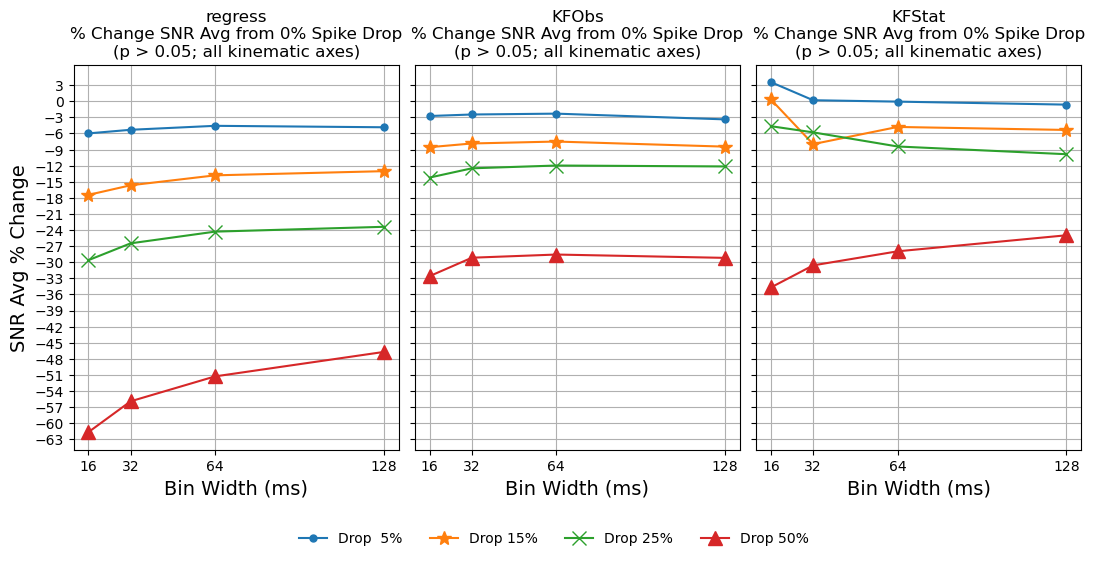

In [751]:
f, ax = plt.subplots(1,3, sharey=True, figsize=(13,5))

cm = plt.get_cmap('gist_rainbow')

for i,j in enumerate(["regress", "KFObs", "KFStat"]):
    # get dfSpikeD_res by decoder
    df_dec = dfSpikeD_res.iloc[np.where(dfSpikeD_res["Decoder"] == j)[0]]
    
    # drop combined kinematic axes and bin width results
    df_dec.drop(index=df_dec.iloc[np.where(df_dec["Bin (ms)"] == "combined")[0]].index.tolist(), inplace=True)
    df_dec.drop(index=df_dec.iloc[np.where(df_dec["KinState"] != "combined")[0]].index.tolist(), inplace=True)

    minR = 0
    maxR = 0
    c = 0
    snr_change_D05_per = []
    snr_change_D15_per = []
    snr_change_D25_per = []
    snr_change_D50_per = []
    for k in np.unique(df_dec["Bin (ms)"]):
        df_dec_bin = df_dec.iloc[np.where(df_dec["Bin (ms)"] == k)[0]]
    
        snr_change_str = df_dec_bin["SNR Change<br>( 5% drop)<br>(@ p Level)"].to_string(index=False).split("%<br>(p > 0.05)\n")
        snr_change_str[-1] = snr_change_str[-1].split("%<br>(p > 0.05)")[0]
        snr_change_D05_per.append([float(s) for s in snr_change_str][0])

        snr_change_str = df_dec_bin["SNR Change<br>(15% drop)<br>(@ p Level)"].to_string(index=False).split("%<br>(p > 0.05)\n")
        snr_change_str[-1] = snr_change_str[-1].split("%<br>(p > 0.05)")[0]
        snr_change_D15_per.append([float(s) for s in snr_change_str][0])

        snr_change_str = df_dec_bin["SNR Change<br>(25% drop)<br>(@ p Level)"].to_string(index=False).split("%<br>(p > 0.05)\n")
        snr_change_str[-1] = snr_change_str[-1].split("%<br>(p > 0.05)")[0]
        snr_change_D25_per.append([float(s) for s in snr_change_str][0])

        snr_change_str = df_dec_bin["SNR Change<br>(50% drop)<br>(@ p Level)"].to_string(index=False).split("%<br>(p > 0.05)\n")
        snr_change_str[-1] = snr_change_str[-1].split("%<br>(p > 0.05)")[0]
        snr_change_D50_per.append([float(s) for s in snr_change_str][0])

        minR = min([minR, round(min(snr_change_D05_per)),round(min(snr_change_D15_per)),\
                          round(min(snr_change_D25_per)),round(min(snr_change_D50_per))])
        maxR = max([maxR, round(max(snr_change_D05_per)),round(max(snr_change_D15_per)),\
                          round(max(snr_change_D25_per)),round(max(snr_change_D50_per))])
        
    ax[i].plot(np.unique(df_dec["Bin (ms)"]), (snr_change_D05_per), '.-', ms=10, label="Drop  5%")
    ax[i].plot(np.unique(df_dec["Bin (ms)"]), (snr_change_D15_per), '*-', ms=10, label="Drop 15%")
    ax[i].plot(np.unique(df_dec["Bin (ms)"]), (snr_change_D25_per), 'x-', ms=10, label="Drop 25%")
    ax[i].plot(np.unique(df_dec["Bin (ms)"]), (snr_change_D50_per), '^-', ms=10, label="Drop 50%")
    c += 1

    if (minR < -60):
        minR = -60

    if (maxR > 100):
        maxR = 100

    ax[i].set_xticks(np.unique(df_dec["Bin (ms)"]).astype("int"))
    ax[i].grid(which="minor")
    ax[i].grid(which="major")
    ax[i].set_yticks(np.arange(-63,3+3,3))
    # ax[i].set_ylim([minR-2,maxR+2])
    ax[i].set_xlabel("Bin Width (ms)", fontsize=14);
    ax[i].set_title(j + "\n% Change SNR Avg from 0% Spike Drop\n(p > 0.05; all kinematic axes)")

ax[0].set_ylabel("SNR Avg % Change", fontsize=14)
ax[-1].legend(frameon=False, ncols=6, bbox_to_anchor=(0.2, -0.18))
plt.subplots_adjust(wspace=0.05)

<font color='gray'>*Figure 12. The plots in this figure show avg SNR performance from a baseline (0% of dropped spikes) for the case of 5%, 15%, 25%, and 50% of dropped (removed) spikes from single-unit neural data passed into each decoder. Each individual line considers all kinematic states combined for spikes processed at different bin widths. These results show the difference in avg SNR performance at the 95% confidence level (p>0.05) obtained from bootstrapping for 100,000 results.*</font>

From the plots output from the code above, a few observations: one, the drop off in performance for the linear regression decoder is also linear and matches, for the most part, the drop in spike % (e.g. 15 % random drop in spikes results in 15 % of drop in SNR performance); second, the KF Supervised has a drop in performance of only ~2-3 %, ~7-9 % and ~12-14 % when presented with SU neural data that has 5 %, 15 %, and 25 % respectively of spikes randomly dropped from it when considering any bin size with combined kinematic axis results (p > 0.05); finally, the KF static decoder demonstrates an improvement, or approximately no affect, in SNR when dropping 5 % of neural spikes for any bin size and considering all kinematic results combined (p > 0.05). Also, the KF unsupervised decoder demonstrates $5$-$6$ % drop in performance when considering randomly dropping 25 % of neural spike data when considering results for bin widths 16ms and 32ms and kinematic axes combined.

# Conclusion

This project's goal was to create a Python library for neural signal decoding. This project implemented three neural decoders: linear regression; KF supervised; and KF unsupervised with static mapping to the states of interest. In linear regression, a least squares approximation was performed to learn coefficients for a model that linearly transforms the neural spike data to the states of interest. In the KF supervised, the parameters for a linear-Gaussian dynamical system (LGDS) model are learned from ground truth data, or the states of interest, then a standard KF is applied on the neural observational data to generate estimates for the states of interest and minimize their uncertainty over time. The KF unsupervised decoder does not have access to ground truth data at time of training and so an expectation maximization algorithm is applied to train the LGDS model as a system of latent states and neural data. The EM algorithm in KF unsupervised is initialized with Factor Analysis and it makes use of a KF with a Rauch-Tung-Striebel Smoother in its expectation step. Following training, the KF unsupervised applies a standard KF to estimate latent states given observational neural data. A static linear transformation can then be applied to map the latent states back to the states of interest.

The linear regression neural signal decoder implemented here matched closely to published results for the same decoder applied on a published dataset— demonstrating a performance difference of $\lt 2$ % in average SNR when considering all possible kinematic axes and binning (with $\lt 1$ % in standard error for a bootstrap distribution of averages). For the same consideration, the KF supervised also demonstrated results that matched closely with published results on the published dataset ($\approx 2$ % difference in SNR average with $\lt 1$ % in standard error in bootstrap distribution). The KF unsupervised with static mapping decoder implemented did not match the reference decoder's published results but proved to outperform it. When considering all possible kinematic axes and binning, the custom implementation of the KF unsupervised demonstrated an increase $> 59$ % than its reference decoder's average SNR performance (p > 0.05).

In testing MU data on the decoders, it generally underperformed the SU data by an SNR amount > 10 % (and much greater at times) for all decoders. Though, when considering 128 ms bin sizes and acceleration estimation, MU data caused only a drop by $< 4$ % and $< 1$ % in SNR for the acceleration x and y axes respectively for the KF supervised decoder (p > 0.15); regression demonstrated an increase of $>27$ % and $>82$ % in SNR for the same axes and consideration (p > 0.15).

In testing how well neural decoders handle spike dropping: the regression decoder, in most cases, dropped off in SNR performance linearly and at the same percentage as the percentage of spikes dropped from the observational data; the KF supervised dropped off in SNR performance at ~2-3 %, ~7-9 % and ~12-14 % when 5 %, 15 %, and 25 % of SU neural spikes were randomly removed respectively and when considering any bin size and all kinematic axis results combined (p > 0.05); the KF unsupervised decoder implemented here demonstrated improvement, or no affect, in SNR when randomly dropping 5 % of neural spikes (considering any binning for all kinematics combined) and exhibited a degradation of $\lt 5$ % when 25 % of spikes were dropped (considering the results for all bin widths and kinematic axes combined).

All in all, this project was initiated with the goal to produce a neural signal decoding library in Python that is sufficiently documented. The hope is that the library implemented here, with its ability to reproduce results from published data on a published dataset, would prove convenient and allow researchers to extend functionalities and contribute freely. Lastly, in considering future efforts: adding the rEFH decoder to this library; figuring out why the results for the "loco" sessions do not match that reported in the results file accompanying the dataset used here; and making a comparison among decoders in their ability to transfer learning could all be beneficial to explore. The rEFH decoders from [Makin et al., 2018](https://iopscience.iop.org/article/10.1088/1741-2552/aa9e95) demonstrated superior performance (in SNR) to other decoders in that paper for their main experiment (binning at 64 ms). The dataset that this library is built from features 2 subjects, 47 different experimental sessions, and contains data collected over a span of 329 days, which makes this interesting when considering it for exploration of transfer learning. For example, how will parameters learned from one subject or from days back transfer over to a new experimental session?


# Appendix

## Derivation of Posterior Distribution Parameters for Factor Analysis

The expectation and variance for the posterior in factor analysis can be found using the properties for conditional properties of bi-variate normal distributions. Specifically, the properties that states the conditional mean and variance of two Random Variables (RV) (say $\pmb{X}$ and $\pmb{Y}$) can be found respectively as:

$$E[\pmb{X}|\pmb{Y}] = E[\pmb{X}] + \pmb{\rho} \frac{\pmb{\sigma}_X}{\pmb{\sigma}_Y}(\pmb{Y} - E[\pmb{Y}])\tag{A1}$$

$$Cov[\pmb{X}|\pmb{Y}] = \pmb{\sigma}_X (\pmb{I} - \pmb{\rho}^2)\tag{A2}$$

where, 

$\pmb{\sigma}$ is the standard deviation for the RV specified in the subscript following the symbol;

$\pmb{\rho}$ is the correlation coefficient that specifies the statistical relationship between the RV's $\pmb{X}$ and $\pmb{Y}$ and is defined as $\pmb{\rho}=\frac{Cov[\pmb{X},\pmb{Y}]}{\pmb{\sigma}_X\pmb{\sigma}_Y}$
<br>
<br>
<br>
### Derivation of Posterior Expectation for Factor Analysis

Now, find the expected expression for the posterior in FA, $E[\pmb{z}_m|\pmb{r}_m]$. Note: the subscript $m$ will be dropped going forward for brevity and since all samples are assumed independent and identically distributed (IID):

First, plug the latent state and observational data for $\pmb{X}$ and $\pmb{Y}$ respectively into Equation (A1):

$$E[\pmb{z}|\pmb{r}] = E[\pmb{z}] + \pmb{\rho} \frac{\pmb{\sigma}_{z}}{\pmb{\sigma}_{r}}(\pmb{r} - E[\pmb{r}])$$

In factor analysis, the prior distribution is assumed $p(\pmb{z})~N(0,I_N)$ and so the expectation $E[\pmb{z}]$ and standard deviation $\pmb{\sigma}_{z}$ can be set to 0 and $\pmb{I_N}$, respectively. The expectation of the observed data is $\pmb{\mu}$ so that can be updated in the equation as well. Also, plug in the definition for $\pmb{\rho}$:

$$\Rightarrow E[\pmb{z}|\pmb{r}] = \frac{Cov[\pmb{z},\pmb{r}]}{\pmb{\sigma}_{z}\pmb{\sigma}_{r}} \frac{1}{\pmb{\sigma}_{r}}(\pmb{r} - \pmb{\mu}) = \frac{Cov[\pmb{z},\pmb{r}]}{\pmb{\sigma}_{r}{\pmb{\sigma}_{r}}'} (\pmb{r} - \pmb{\mu}) = \frac{Cov[\pmb{z},\pmb{r}]}{Cov[\pmb{r},\pmb{r}]} (\pmb{r} - \pmb{\mu})$$

Using the definition of covariance that says $Cov[\pmb{X},\pmb{Y}] = E[\pmb{X}\pmb{Y}'] - E[\pmb{X}]E[\pmb{Y}]'$, the above becomes:

$$\Rightarrow E[\pmb{z}|\pmb{r}] = \frac{E[\pmb{z}\pmb{r}'] - E[\pmb{z}]E[\pmb{r}]'}{E[\pmb{r}\pmb{r}'] - E[\pmb{r}]E[\pmb{r}]'} (\pmb{r} - \pmb{\mu}) = \frac{E[\pmb{z}\pmb{r}']}{E[\pmb{r}\pmb{r}'] - \pmb{\mu}\pmb{\mu}'} (\pmb{r} - \pmb{\mu})$$

(since $E[\pmb{z}]=0$ and $E[\pmb{r}]=\pmb{\mu}$).

Plugging in the FA LGDS model for the observation data, $\pmb{r}$:

$$\Rightarrow E[\pmb{z}|\pmb{r}] = \frac{E[\pmb{z}(\pmb{L}\pmb{z}+\pmb{\mu}+\epsilon)']}{E[(\pmb{L}\pmb{z}+\pmb{\mu}+\epsilon)(\pmb{L}\pmb{z}+\pmb{\mu}+\epsilon)'] - \pmb{\mu}\pmb{\mu}'} (\pmb{r} - \pmb{\mu})$$

Expanding multiplication:

$$\Rightarrow E[\pmb{z}|\pmb{r}] = 
\frac{
E[\pmb{z}\pmb{z}'\pmb{L}']+
E[\pmb{z}\pmb{\mu}']+
E[\pmb{z}\epsilon']
}{
E[\pmb{L}\pmb{z}\pmb{z}'\pmb{L}']+
E[\pmb{L}\pmb{z}\pmb{\mu}']+
E[\pmb{L}\pmb{z}\epsilon']+
E[\pmb{\mu}\pmb{z}'\pmb{L}']+
E[\pmb{\mu}\pmb{\mu}']+
E[\pmb{\mu}\epsilon']+
E[\epsilon\pmb{z}'\pmb{L}']+
E[\epsilon\pmb{\mu}']+
E[\epsilon\epsilon']-
\pmb{\mu}\pmb{\mu}'
}(\pmb{r} - \pmb{\mu})$$

$$\Rightarrow E[\pmb{z}|\pmb{r}] = 
\frac{
E[\pmb{z}\pmb{z}'\pmb{L}']
}{
E[\pmb{L}\pmb{z}\pmb{z}'\pmb{L}']+
E[\pmb{\mu}\pmb{\mu}']+
E[\epsilon\epsilon']-
\pmb{\mu}\pmb{\mu}'
}(\pmb{r} - \pmb{\mu})$$

(which is a result of removing the Expectations that are 0 (include just $\pmb{z}$ or just $\epsilon$ and a possible constant or both the product of $\pmb{z}$ and $\epsilon$)). Moving constants out of the expectations:

$$\Rightarrow E[\pmb{z}|\pmb{r}] = 
\frac{
E[\pmb{z}\pmb{z}']\pmb{L}'
}{
\pmb{L}E[\pmb{z}\pmb{z}']\pmb{L}'+
\pmb{\mu}\pmb{\mu}'+
E[\epsilon\epsilon']-
\pmb{\mu}\pmb{\mu}'
}(\pmb{r} - \pmb{\mu})$$

and since $E[\pmb{z}\pmb{z}']=\pmb{I_N}$ and $E[\epsilon\epsilon']=\pmb{\Psi}$:

$$\Rightarrow E[\pmb{z}|\pmb{r}] = 
\frac{
\pmb{L}'
}{
\pmb{L}\pmb{L}'+
\pmb{\Psi}
}(\pmb{r} - \pmb{\mu})
=\boxed{\pmb{L}'
(\pmb{L}\pmb{L}'+\pmb{\Psi})^{-1}
(\pmb{r} - \pmb{\mu})}
\text{ or }
\boxed{\pmb{\beta}
(\pmb{r} - \pmb{\mu})}$$

<br>
<br>

### Derivation of Posterior Variance for Factor Analysis

Next, for the derivation of the variance for the posterior, plug in the definition for $\pmb{\rho}$ and replace $\pmb{X}$ and $\pmb{Y}$ with the latent state and observational data respectively for Equation (A2):

$$Cov[\pmb{z}|\pmb{r}] =
\pmb{\sigma}_z
(
\pmb{I_N} -
\frac{
Cov[\pmb{z},\pmb{r}]
}{
\pmb{\sigma}_z\pmb{\sigma}_r
}
\frac{
Cov[\pmb{z},\pmb{r}]'
}{
\pmb{\sigma}_r'\pmb{\sigma}_z'
}
) =
(
\pmb{I_N} -
\frac{
Cov[\pmb{z},\pmb{r}]Cov[\pmb{z},\pmb{r}]'
}{
\pmb{\sigma}_r\pmb{\sigma}_r'
}
) =
(
\pmb{I_N} -
\frac{
Cov[\pmb{z},\pmb{r}]Cov[\pmb{z},\pmb{r}]'
}{
Cov[\pmb{r},\pmb{r}]
}
)$$

which, as was seen in the Derivation of Posterior Expectation, $\frac{Cov[\pmb{z},\pmb{r}]}{Cov[\pmb{r},\pmb{r}]} = \pmb{\beta}$ and $Cov[\pmb{z},\pmb{r}]=\pmb{L}'$, so:

$$\Rightarrow{
\boxed{
Cov[\pmb{z}|\pmb{r}] =
(
\pmb{I_N}- \pmb{\beta}\pmb{L}
)
}}
$$